# Analise de aluguel de imoveis São Paulo


## Importando Libs


In [2]:
import pandas as pd
import time
import numpy as np
import joblib
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans, DBSCAN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from matplotlib.ticker import FuncFormatter

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
import time
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels

## Carregamento dos Dataset


In [3]:
df = pd.read_csv('/home/fbotero/Downloads/imoveis/dados/data.csv')
df.head()

,address,district,area,bedrooms,garage,type,rent,total
0,Rua Herval,Belenzinho,21,1,0,Studio e kitnet,2400,2939
1,Avenida São Miguel,Vila Marieta,15,1,1,Studio e kitnet,1030,1345
2,Rua Oscar Freire,Pinheiros,18,1,0,Apartamento,4000,4661
3,Rua Júlio Sayago,Vila Ré,56,2,2,Casa em condomínio,1750,1954
4,Rua Barata Ribeiro,Bela Vista,19,1,0,Studio e kitnet,4000,4654


## Analise de Dados


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11657 entries, 0 to 11656
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   address   11657 non-null  object
 1   district  11657 non-null  object
 2   area      11657 non-null  int64 
 3   bedrooms  11657 non-null  int64 
 4   garage    11657 non-null  int64 
 5   type      11657 non-null  object
 6   rent      11657 non-null  int64 
 7   total     11657 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 728.7+ KB


In [5]:
df.describe()

,area,bedrooms,garage,rent,total
count,11657.000000,11657.000000,11657.000000,11657.000000,11657.000000
mean,84.655658,1.966286,1.060393,3250.814789,4080.030625
std,74.020536,0.931313,1.132349,2650.711557,3352.480274
min,0.000000,0.000000,0.000000,500.000000,509.000000
25%,40.000000,1.000000,0.000000,1590.000000,1996.000000
50%,60.000000,2.000000,1.000000,2415.000000,3057.000000
75%,96.000000,3.000000,2.000000,3800.000000,4774.000000
max,580.000000,6.000000,6.000000,25000.000000,28700.000000


In [6]:
df.isnull().sum()

address     0
district    0
area        0
bedrooms    0
garage      0
type        0
rent        0
total       0
dtype: int64

## Visualização de Dados


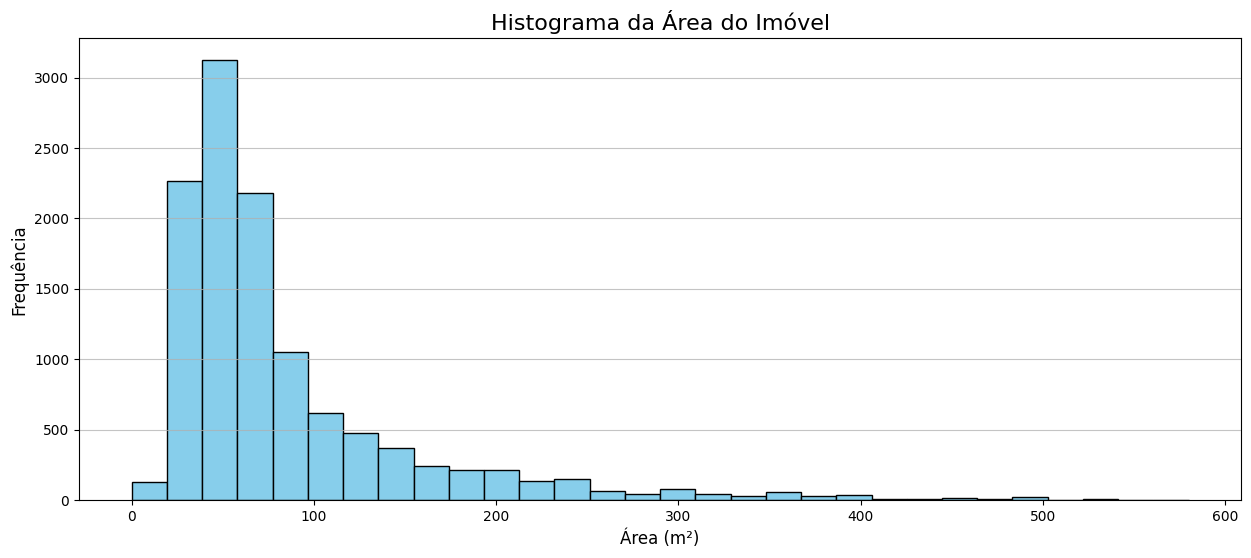

In [7]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.hist(df.area, bins=30, color='skyblue', edgecolor='black')
ax.set_title('Histograma da Área do Imóvel', fontsize=16)
ax.set_xlabel('Área (m²)', fontsize=12)
ax.set_ylabel('Frequência', fontsize=12)
ax.grid(axis='y', alpha=0.75)

count    11657.000000
mean        84.655658
std         74.020536
min          0.000000
25%         40.000000
50%         60.000000
75%         96.000000
max        580.000000
Name: area, dtype: float64

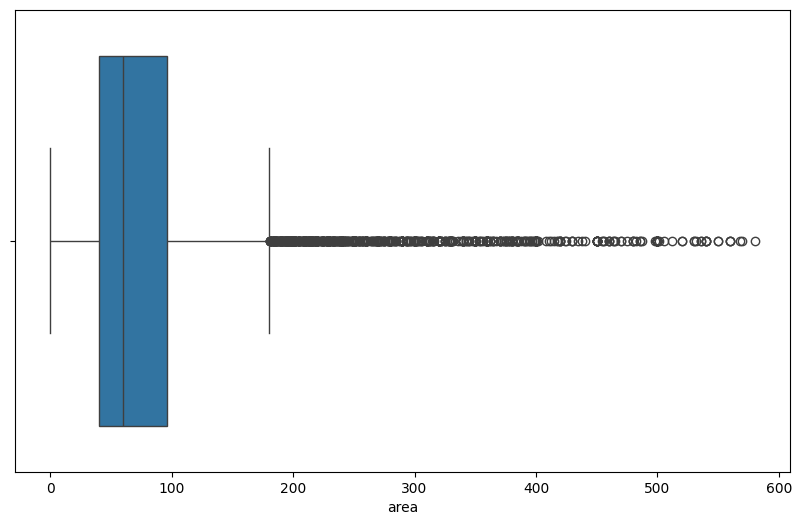

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['area'])
df.area.describe()

### Correlação entre os dados

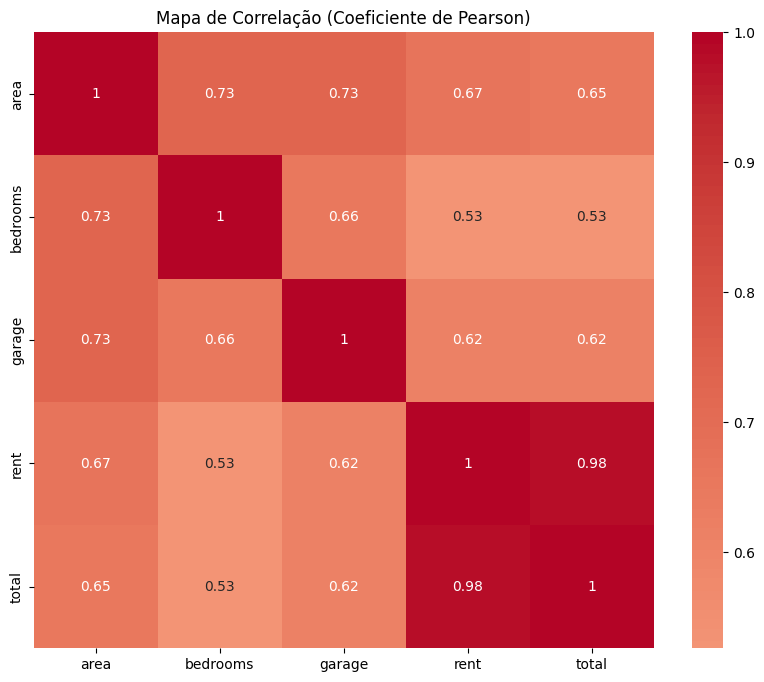

In [12]:
numeric_cols = df.select_dtypes(include=["int64", "float64"])

corr = numeric_cols.corr(method="pearson")

# Plotar heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Mapa de Correlação (Coeficiente de Pearson)")
plt.show()

#### Area com menor valor de aluguel


In [9]:
df[df.rent == 500]

,address,district,area,bedrooms,garage,type,rent,total
51,Rua Tanque Velho,Vila Nivi,45,1,0,Casa,500,551
1188,Viela Renaldo Laporta,Vila Aurora (zona Norte),30,1,0,Casa,500,521
4741,Rua Manoel Oliveira Gonçalves,Jardim Jaçanã,30,1,0,Casa,500,509
5901,Rua Manuel José Rodrigues,Sacoma,40,1,0,Casa,500,521
6428,Rua Eugênia S Vitale,Taboão,30,1,0,Studio e kitnet,500,594
7420,Rua Manuel José Rodrigues,Sacoma,20,1,0,Casa,500,521
10559,Rua Arraial de São Bartolomeu,Vila Carmosina,70,2,0,Casa,500,821


## Limpeza de Dados


In [9]:
# Normaliza os nomes dos bairros para padronização
df['district'] = df['district'].str.lower().str.strip()
# Mapeamento manual de variações para nomes oficiais.
# Adicione mais mapeamentos aqui conforme necessário.
mapeamento_nomes = {
    'vila aricanduva': 'Aricanduva',
    'jardim aricanduva': 'Aricanduva',
    'agua branca': 'Água Branca',
    'agua fria': 'Água Fria',
    'agua rasa': 'Água Rasa',
    'bras': 'Brás',
    'santa cecilia': 'Santa Cecília',
    'santa ifigenia': 'Santa Efigênia',
    'chacara santo antonio (zona sul)': 'Chácara Santo Antônio',
    'chacara santo antonio (zona leste)': 'Chácara Santo Antônio',
    'jardim santa cruz (campo grande)': 'Campo Grande',
    'jardim sao paulo(zona norte)': 'Jardim São Paulo',
    'parque são lucas': 'São Lucas',
    'parque da vila prudente': 'Vila Prudente',
    'vila sonia': 'Vila Sônia',
    'bosque da saude': 'Saúde',
    'vila da saude': 'Saúde',
    'jardim da saude': 'Saúde',
    'parque jabaquara': 'Jabaquara',
    'vila parque jabaquara': 'Jabaquara',
    'jardim jabaquara': 'Jabaquara',
    'jardim analia franco': 'Jardim Anália Franco',
    'vila pompéia': 'Pompéia',
    'varzea da barra funda': 'Barra Funda',
    'lapa de baixo': 'Lapa',
    'parque da lapa': 'Lapa',
    'parque residencial da lapa': 'Lapa',
    'jardim das perdizes': 'Perdizes',
    'saco ma': 'Sacomã',
    'jardim vergueiro (sacomã)': 'Sacdf[df.rent == 500]omã',
    'jardim santa cruz (sacomã)': 'Sacomã',
    'vila matiilde': 'Vila Matilde',
    'centro capital': 'Centro',
    'vila brasilandia': 'Brasilândia',
    'vila pirituba': 'Pirituba',
    'jardim cidade pirituba': 'Pirituba',
    'jardim pirituba': 'Pirituba',
    'republica': 'República',
    'jardim rio pequeno': 'Rio Pequeno',
    'parque da mooca': 'Mooca',
    'vila butanta': 'Butantã',
    'conjunto residencial butantã': 'Butantã',
    'vila brasilandia': 'Brasilândia',
    'vila butanta': 'Butantã',
    'conjunto residencial butantã': 'Butantã',
    'nossa senhora do ó': 'Freguesia do Ó',
    'nossa senhora do o': 'Freguesia do Ó',
    'penha de frança': 'Penha',
    'jardim penha': 'Penha',
    'jardim america da penha': 'Penha',
    'jardim paulistano': 'Jardim Paulista',
    'jardim peri peri': 'Jardim Peri',
    'vila são josé (ipiranga)': 'Ipiranga',
    'vila maria alta': 'Vila Maria',
    'vila maria baixa': 'Vila Maria',
    'jardim vila mariana': 'Vila Mariana',
    'panamby': 'Panamby',
    'super quadra morumbi': 'Morumbi',
    'recanto morumbi': 'Morumbi',
    'jardim parque morumbi': 'Morumbi',
    'parque bairro morumbi': 'Morumbi',
    'jardim independencia (são paulo)': 'Jardim Independência',
    'jardim panaroma (zona leste)': 'Jardim América',
    'brooklin novo': 'Brooklin',
    'brooklin paulista': 'Brooklin',
}

# Aplica o mapeamento para criar a coluna de bairro oficial
df['district'] = df['district'].apply(
    lambda x: mapeamento_nomes.get(x, x.title())
)

### Tratando os outliers


Consideramos imóveis entre 40m² e 90m², pois refletem o padrão de apartamentos destinados à
classe média, segundo dados do mercado imobiliário.”


In [10]:
print(df.iloc[7420])
df = df[df.area >= 20]
df = df[df.area < 90]
df.describe()

address     Rua Manuel José Rodrigues
district                       Sacoma
area                               20
bedrooms                            1
garage                              0
type                             Casa
rent                              500
total                             521
Name: 7420, dtype: object


,area,bedrooms,garage,rent,total
count,8276.000000,8276.000000,8276.000000,8276.000000,8276.000000
mean,50.707347,1.592073,0.639439,2313.761479,2932.239004
std,17.067264,0.644834,0.644764,1393.406429,1723.223935
min,20.000000,0.000000,0.000000,500.000000,509.000000
25%,37.000000,1.000000,0.000000,1400.000000,1747.000000
50%,50.000000,2.000000,1.000000,2000.000000,2543.000000
75%,64.000000,2.000000,1.000000,2810.000000,3652.250000
max,89.000000,4.000000,5.000000,25000.000000,26710.000000


<Axes: xlabel='area'>

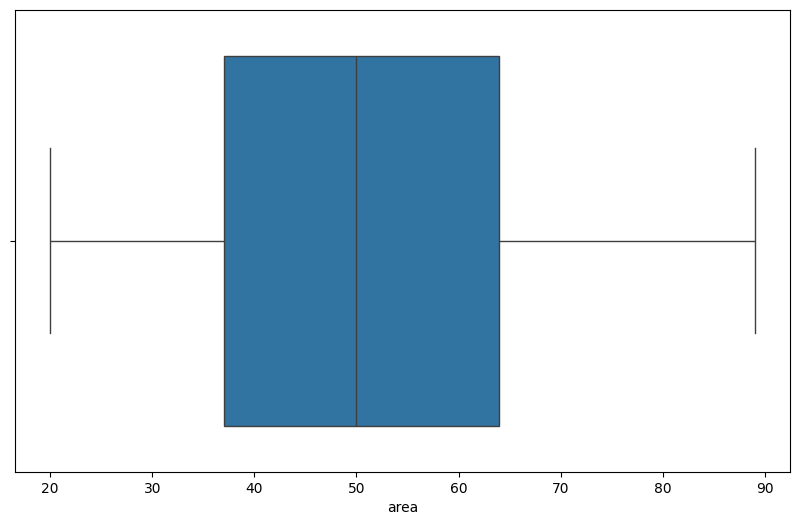

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['area'])

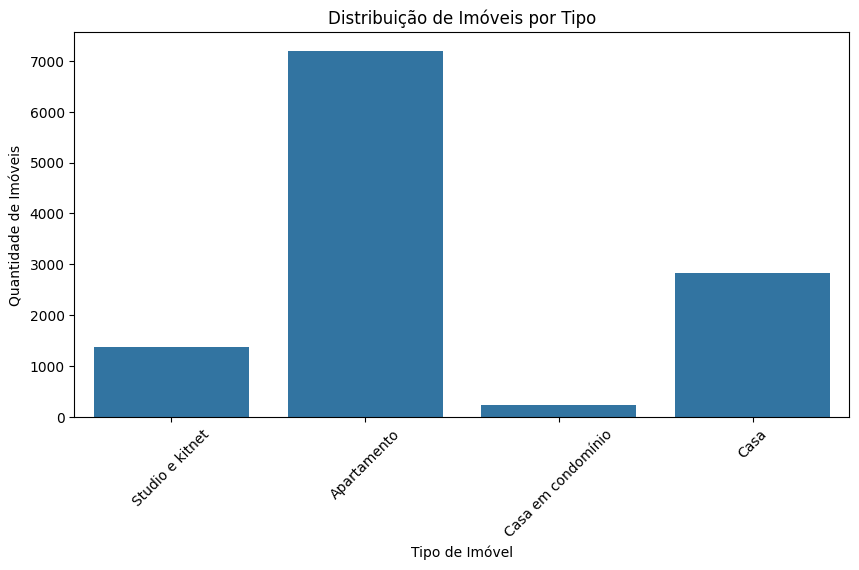

In [11]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='type')
plt.title('Distribuição de Imóveis por Tipo')
plt.xticks(rotation=45)
plt.ylabel('Quantidade de Imóveis')
plt.xlabel('Tipo de Imóvel')
plt.show()

#### Removendo imoveis sem quartos


In [12]:
df = df[df.bedrooms >= 1]
df.describe()

,area,bedrooms,garage,rent,total
count,8245.000000,8245.000000,8245.000000,8245.000000,8245.000000
mean,50.769436,1.598059,0.641601,2316.470467,2935.720558
std,17.055005,0.638598,0.644833,1394.657523,1724.806960
min,20.000000,1.000000,0.000000,500.000000,509.000000
25%,37.000000,1.000000,0.000000,1400.000000,1750.000000
50%,50.000000,2.000000,1.000000,2000.000000,2545.000000
75%,64.000000,2.000000,1.000000,2820.000000,3657.000000
max,89.000000,4.000000,5.000000,25000.000000,26710.000000


## Engenharia de Features


#### Removendo features que não serão utilizadas


In [13]:
df_clean = df.drop(columns=['rent','address'])

#### Criando coluna "price_m2"


In [14]:
df_clean["price_m2"] = df_clean["total"] / df_clean["area"]
df_clean.price_m2.describe()

count    8245.000000
mean       61.374726
std        37.250008
min         9.650000
25%        37.628571
50%        51.500000
75%        74.543210
max      1112.916667
Name: price_m2, dtype: float64

#### Criando coluna "price_level"


Foi utilizado dados a partir de uma pesquisa de mercado para entender os valores do m2 de alguel em SP, assim substituimos so valores dos quartis na nossa analise para os encotrados


In [15]:
bins = [9, 50, 70,90 , 1115]
labels = ["Baixo", "Medio", "Alto", "Muito Alto"]

df_clean["price_level"] = pd.cut(
    df_clean["price_m2"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

#### Distribuição de Imoveis Preço Total


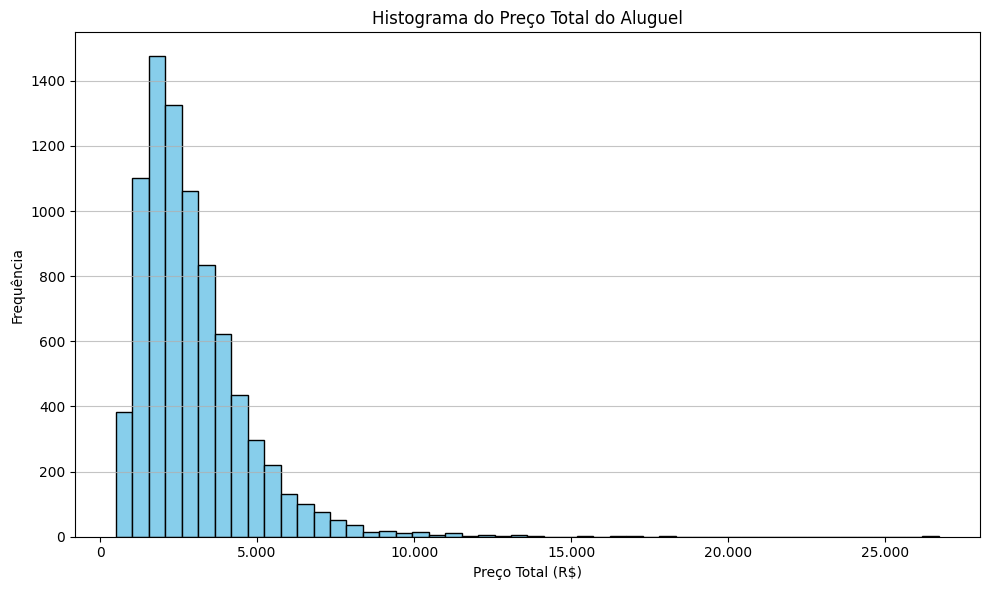

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(df_clean['total'], bins=50, color='skyblue', edgecolor='black')

ax.set_title('Histograma do Preço Total do Aluguel')
ax.set_xlabel('Preço Total (R$)')
ax.set_ylabel('Frequência')
ax.grid(axis='y', alpha=0.75)

ax.get_xaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,.0f}".format(x).replace(",", "."))
)

plt.tight_layout()

#### Distribuição de Imoveis Preço m2


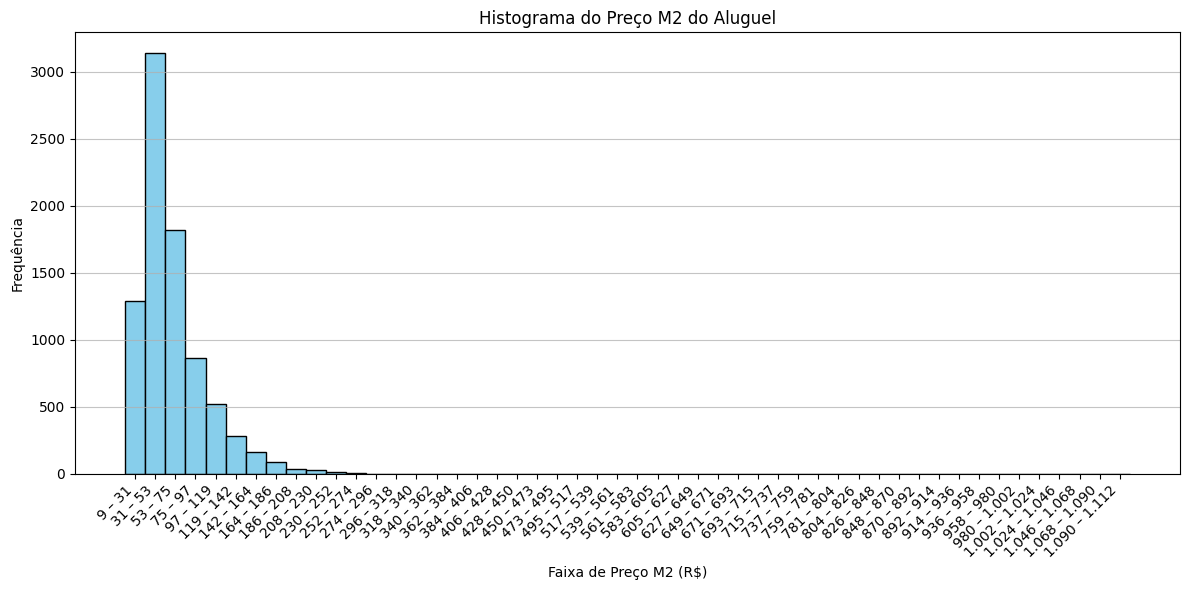

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))

counts, bins, patches = ax.hist(
    df_clean['price_m2'], bins=50, color='skyblue', edgecolor='black'
)

bin_labels = [f"{int(bins[i]):,} – {int(bins[i+1]):,}".replace(",", ".")
              for i in range(len(bins)-1)]

bin_centers = (bins[:-1] + bins[1:]) / 2
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels, rotation=45, ha="right")

ax.set_title("Histograma do Preço M2 do Aluguel")
ax.set_xlabel("Faixa de Preço M2 (R$)")
ax.set_ylabel("Frequência")
ax.grid(axis="y", alpha=0.75)

plt.tight_layout()
plt.show()


#### Mapear bairros para cada faixa


In [18]:
bins = [9, 50, 70,90 , 1115]
labels = ["Baixo", "Médio", "Alto", "Muito Alto"]

df_clean["faixa_preco_m2"] = pd.cut(df_clean["price_m2"], bins=bins, labels=labels, include_lowest=True)

# Contagem de imóveis por distrito dentro de cada faixa
concentracao = df_clean.groupby(["faixa_preco_m2", "district"]).size().reset_index(name="quantidade")

# Para cada faixa, pegar o distrito com maior concentração
top_distritos = concentracao.loc[concentracao.groupby("faixa_preco_m2")["quantidade"].idxmax()]

top_distritos


/tmp/ipykernel_79423/2679612559.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  concentracao = df_clean.groupby(["faixa_preco_m2", "district"]).size().reset_index(name="quantidade")
/tmp/ipykernel_79423/2679612559.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_distritos = concentracao.loc[concentracao.groupby("faixa_preco_m2")["quantidade"].idxmax()]


,faixa_preco_m2,district,quantidade
17,Baixo,Bela Vista,88
1003,Médio,Bela Vista,78
1989,Alto,Bela Vista,61
3770,Muito Alto,Vila Mariana,92


#### Distribuição Bairro e Nível de Preço


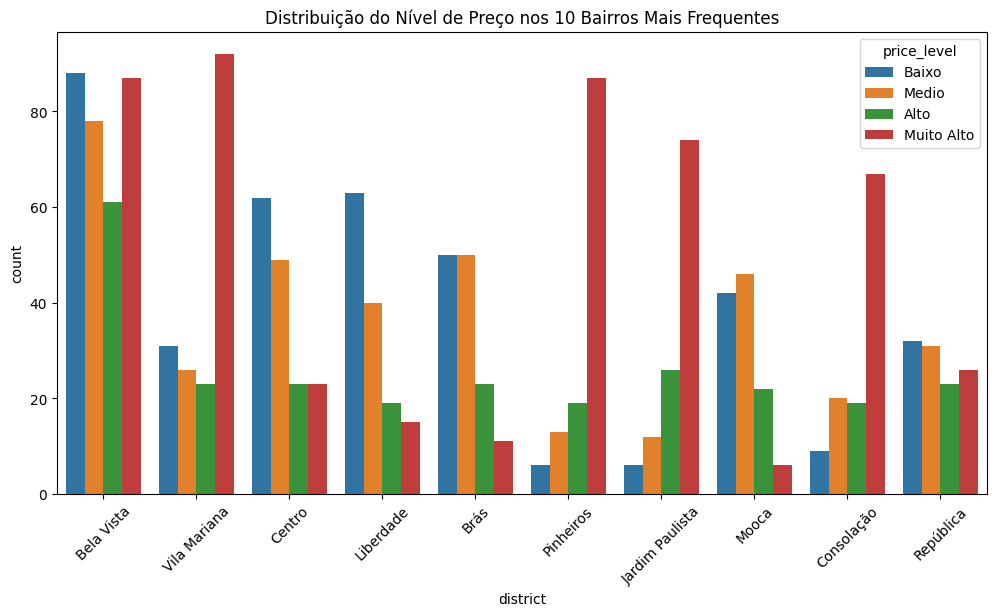

In [19]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_clean, x='district', hue='price_level', order=df_clean['district'].value_counts().iloc[:10].index)
plt.title('Distribuição do Nível de Preço nos 10 Bairros Mais Frequentes')
plt.xticks(rotation=45)
plt.show()

#### Distribuição Tipo de Imóvel e Nível de Preço


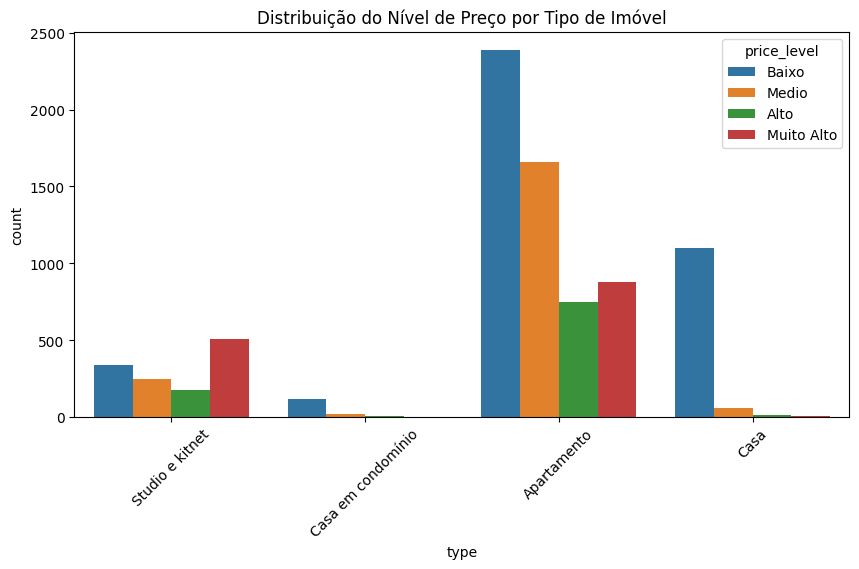

In [20]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df_clean, x='type', hue='price_level')
plt.title('Distribuição do Nível de Preço por Tipo de Imóvel')
plt.xticks(rotation=45)
plt.show()

### Correlação de Pearson


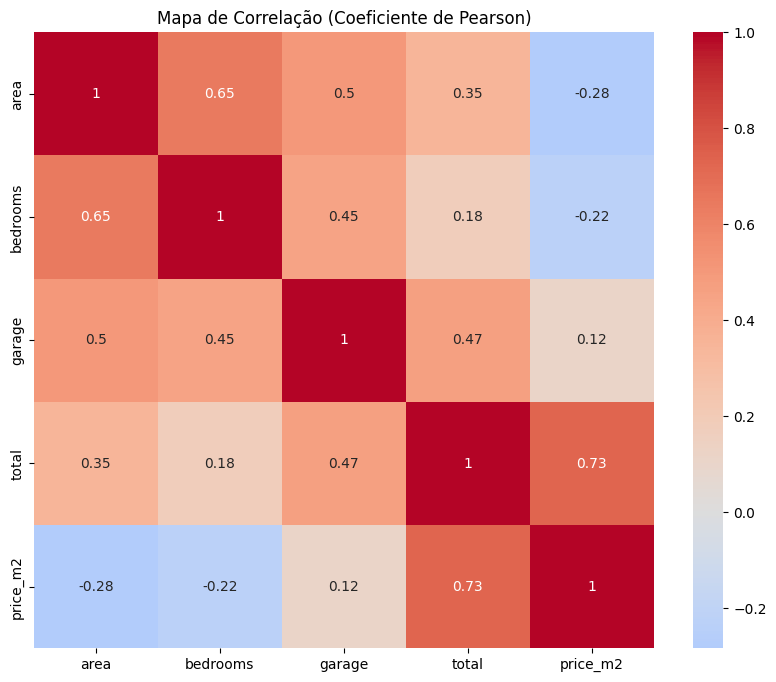

In [21]:
numeric_cols = df_clean.select_dtypes(include=["int64", "float64"])

corr = numeric_cols.corr(method="pearson")

# Plotar heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Mapa de Correlação (Coeficiente de Pearson)")
plt.show()


#### Removendo linhas com NaN na feature target


In [22]:
df_clean.replace("?", np.nan, inplace=True)
df_clean = df_clean.dropna(subset=["price_level"])
df_clean

,district,area,bedrooms,garage,type,total,price_m2,price_level,faixa_preco_m2
0,Belenzinho,21,1,0,Studio e kitnet,2939,139.952381,Muito Alto,Muito Alto
3,Vila Ré,56,2,2,Casa em condomínio,1954,34.892857,Baixo,Baixo
5,Brás,50,2,1,Apartamento,4587,91.740000,Muito Alto,Muito Alto
6,Brooklin,72,2,1,Apartamento,5187,72.041667,Alto,Alto
7,Centro,26,1,0,Studio e kitnet,2244,86.307692,Alto,Alto
...,...,...,...,...,...,...,...,...,...
11638,Santo Amaro,70,2,1,Apartamento,4215,60.214286,Medio,Médio
11640,Jardim Caravelas,78,2,1,Apartamento,3686,47.256410,Baixo,Baixo
11645,Santo Amaro,70,2,0,Apartamento,3116,44.514286,Baixo,Baixo
11654,Jardim Caravelas,84,1,2,Apartamento,5467,65.083333,Medio,Médio


#### Distribuição Imoveis por Price_level


price_level
Baixo         3936
Medio         1981
Muito Alto    1390
Alto           938
Name: count, dtype: int64


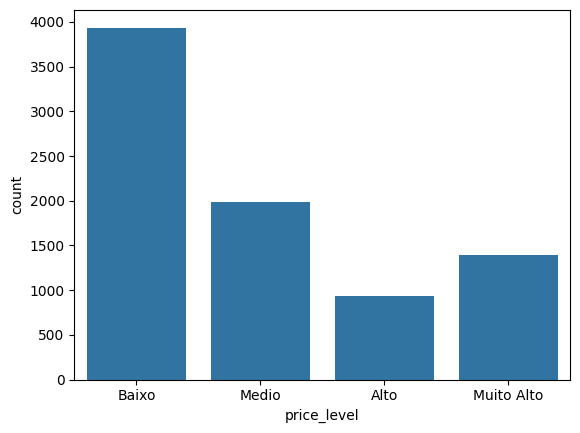

In [23]:
sns.countplot(x = df_clean['price_level'])
print(df_clean["price_level"].value_counts())

## Separação de Dados e Treinamento


#### Divisão entre previsores (X) e classe (y)


In [24]:
target = "price_level"
X = df_clean.drop(columns=[target, 'price_m2', 'total','faixa_preco_m2'])
y = df_clean[target]

print("Features utilizadas para o treinamento:", X.columns.tolist())

Features utilizadas para o treinamento: ['district', 'area', 'bedrooms', 'garage', 'type']


#### Separando variaveis entre numericas e categoricas


In [25]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

#### Escalonamento dos valores e Codificação de variáveis categóricas


In [26]:
ohe_enc = OneHotEncoder(sparse_output=False)
scaler_std = StandardScaler()

X_num_std = scaler_std.fit_transform(df[num_features])
X_nom = ohe_enc.fit_transform(df[cat_features]) if cat_features else np.empty((len(df),0))

X_final = np.hstack([X_num_std, X_nom])
X_final

array([[-1.74560142, -0.93657557, -0.99504865, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.30670651,  0.62944868,  2.10671926, ...,  0.        ,
         1.        ,  0.        ],
       [-0.0451177 ,  0.62944868,  0.5558353 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.12762969,  0.62944868, -0.99504865, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.94855286, -0.93657557,  2.10671926, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.47945391, -0.93657557, -0.99504865, ...,  0.        ,
         0.        ,  0.        ]], shape=(8245, 993))

#### Divisão da Base em treinamento, teste


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

#### Transformer para converter sparse -> dense (para Naive Bayes)


In [28]:
from sklearn.base import BaseEstimator, TransformerMixin
class DenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X_final, y=None):
        return self
    def transform(self, X_final, y=None):
        return X_final.toarray()

#### Configurando modelos


In [29]:
models_default = {
    "LogisticRegression": LogisticRegression(),
    "RandomForest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "NeuralNetwork": MLPClassifier(),
    "NaiveBayes": GaussianNB()
}

#### Configurando Parametros

In [30]:
param_grids = {
    "LogisticRegression": {
        'C': [0.1, 1.0, 10.0],
        'solver': ['lbfgs', 'liblinear'],
        'max_iter': [500, 1000]
    },
    "RandomForest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    },
    "KNN": {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    "DecisionTree": {
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "NeuralNetwork": {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001]
    }
}

In [31]:
resultados = []

#### Configurando treinamento

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

resultados_global = [] 

def treinar_modelos(balanceamento=None, usar_pca=False, tipo_parametros='default', salvar_parametros=True):

    resultados = []
    models_best_parameters = {}

    # Variáveis para armazenar o melhor modelo
    melhor_pipeline = None
    nome_melhor_modelo = ""
    melhor_score = 0.0
    # Aplicar balanceamento, se necessário
    if balanceamento == "SMOTE":
        sm = SMOTE(random_state=42)
        X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
    elif balanceamento == "TomekLinks":
        tml = TomekLinks()
        X_train_bal, y_train_bal = tml.fit_resample(X_train, y_train)
    else:
        X_train_bal, y_train_bal = X_train, y_train

    # Aplicar PCA, se necessário
    if usar_pca:
        pca = PCA(n_components=100)
        X_train_bal = pca.fit_transform(X_train_bal)
        X_test_pca = pca.transform(X_test)
    else:
        X_test_pca = X_test

    # Loop para treinar os modelos
    for name, model in models_default.items():
        param_file = f"/content/dados/parametros_{name}.pkl"
        if os.path.exists(param_file):
            models_best_parameters[name] = joblib.load(param_file)

        descricao_cenario = (
            f"{name} | Balanceamento: {balanceamento if balanceamento else 'Nenhum'} "
            f"| PCA: {'Sim' if usar_pca else 'Não'} | Parametros: {tipo_parametros}"
        )

        print(f"\n==================== {name} ====================")

        # Condicional para NaiveBayes (sem GridSearch)
        if tipo_parametros == "default" or name == "NaiveBayes":
            grid_search = model
        elif tipo_parametros == "grid":
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grids[name],
                cv=5,
                n_jobs=-1,
                scoring='accuracy',
                verbose=1
            )
        elif tipo_parametros == "best":
            if name in models_best_parameters:
                grid_search = model.set_params(**models_best_parameters[name])
            else:
                print(f"Atenção ⚠️: Não encontrei parâmetros salvos para {name}, usando default.")
                grid_search = model

        # Treinamento com medição de tempo
        inicio = time.time()
        grid_search.fit(X_train_bal, y_train_bal)
        fim = time.time()
        tempo_treino = fim - inicio

        # Previsões
        y_pred_test = grid_search.predict(X_test_pca)
        acc_test = accuracy_score(y_test, y_pred_test)

        # Atualizar melhor modelo
        if acc_test > melhor_score:
            print(f"✨ Novo melhor modelo encontrado: {descricao_cenario} com acurácia de {acc_test:.4f}!")
            melhor_score = acc_test
            melhor_pipeline = grid_search
            nome_melhor_modelo = name

        # Classes dinâmicas
        classes = unique_labels(y_test, y_pred_test)
        target_names = [f"Classe {c}" for c in classes]

        # Matriz de Confusão
        cm = confusion_matrix(y_test, y_pred_test, labels=classes)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=target_names, yticklabels=target_names)
        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.title(f'Matriz de Confusão - {descricao_cenario}')
        plt.show()

        # Relatório de classificação
        print(f"\nRelatório de Classificação para {descricao_cenario}:")
        print(classification_report(y_test, y_pred_test, target_names=target_names))
        print(f"Tempo de treinamento: {tempo_treino:.4f} segundos")

        # Salvar resultados
        if name != "NaiveBayes":
            if tipo_parametros == "grid":
                best_params = grid_search.best_params_
                print(f"📌 Melhores parâmetros encontrados para {name}:")
                print(grid_search.best_params_)
            elif tipo_parametros == "best":
                best_params = models_best_parameters.get(name, "N/A")
            else:
                best_params = "N/A"

            resultados.append({
                "Modelo": descricao_cenario,
                "Acurácia Teste": acc_test,
                "Tempo Treinamento (s)": tempo_treino,
                "Melhores Parâmetros": best_params
            })

            # Salvar parâmetros apenas se for grid
            if salvar_parametros and tipo_parametros == "grid":
                joblib.dump(grid_search.best_params_, f'/home/fbotero/Downloads/imoveis/dados/parametros_{name}.pkl')
        else:
            resultados.append({
                "Modelo": descricao_cenario,
                "Acurácia Teste": acc_test,
                "Tempo Treinamento (s)": tempo_treino,
                "Melhores Parâmetros": "N/A"
            })

        print("=" * 52)

    # Comparação final
    df_resultados = pd.DataFrame(resultados)
    display(df_resultados.sort_values(by="Acurácia Teste", ascending=False))

    resultados_global.extend(resultados)

    # Salvar o melhor modelo
    joblib.dump(melhor_pipeline, f'/home/fbotero/Downloads/imoveis/dados/{nome_melhor_modelo}_melhor_modelo.pkl')
    print(f"✨ Melhor modelo salvo: {nome_melhor_modelo} com acurácia de {melhor_score:.4f}!")

    # RETORNA o melhor modelo treinado
    return melhor_pipeline


Cenarios

In [44]:
df_resultados_globais = pd.DataFrame(resultados_global)
df_resultados_globais.head()

,Modelo,Acurácia Teste,Tempo Treinamento (s),Melhores Parâmetros
0,LogisticRegression | Balanceamento: Nenhum | P...,0.653123,7.652923,N/A
1,RandomForest | Balanceamento: Nenhum | PCA: Nã...,0.614312,4.035075,N/A
2,SVM | Balanceamento: Nenhum | PCA: Não | Param...,0.642207,17.101359,N/A
3,KNN | Balanceamento: Nenhum | PCA: Não | Param...,0.591874,0.006812,N/A
4,DecisionTree | Balanceamento: Nenhum | PCA: Nã...,0.589448,0.583081,N/A


In [ ]:
import pandas as pd

# Garantir que tipo_parametros já está extraído
df_resultados_globais["tipo_parametros"] = df_resultados_globais["Modelo"].str.extract(r"Parametros: (\w+)")

# Filtrar apenas os modelos com grid
df_filtrado = df_resultados_globais[df_resultados_globais["tipo_parametros"] == "grid"]

# Extrair o nome base do modelo (primeira parte antes do "|")
df_filtrado["ModeloBase"] = df_filtrado["Modelo"].str.split("|").str[0].str.strip()

# Agora, pegar o melhor por cada modelo base
melhores_por_modelo = df_filtrado.loc[
    df_filtrado.groupby("ModeloBase")["Acurácia Teste"].idxmax()
]

print("Melhor parâmetro (grid) para cada modelo:")
print(melhores_por_modelo[["ModeloBase", "Acurácia Teste", "Melhores Parâmetros"]])
# Selecionar apenas as colunas que você quer salvar
df_to_save = melhores_por_modelo[["ModeloBase", "Acurácia Teste", "Melhores Parâmetros"]]

# Salvar em CSV
df_to_save.to_csv("melhores_modelos_grid.csv", index=False)

print("Arquivo 'melhores_modelos_grid.csv' salvo com sucesso!")

Melhor parâmetro (grid) para cada modelo:
            ModeloBase  Acurácia Teste  \
39        DecisionTree        0.600364   
66                 KNN        0.612492   
35  LogisticRegression        0.651304   
62          NaiveBayes        0.558520   
61       NeuralNetwork        0.649485   
57        RandomForest        0.643420   
37                 SVM        0.642814   

                                  Melhores Parâmetros  
39  {'max_depth': 10, 'min_samples_leaf': 1, 'min_...  
66  {'metric': 'manhattan', 'n_neighbors': 7, 'wei...  
35     {'C': 1.0, 'max_iter': 500, 'solver': 'lbfgs'}  
62                                                N/A  
61  {'activation': 'tanh', 'alpha': 0.001, 'hidden...  
57  {'max_depth': 10, 'min_samples_leaf': 2, 'min_...  
37     {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}  
Arquivo 'melhores_modelos_grid.csv' salvo com sucesso!


/tmp/ipykernel_79423/3896266342.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado["ModeloBase"] = df_filtrado["Modelo"].str.split("|").str[0].str.strip()


In [ ]:
best_params_dict = dict(zip(melhores_por_modelo["ModeloBase"], melhores_por_modelo["Melhores Parâmetros"]))
print(best_params_dict)

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [50]:
best_params_dict = dict(zip(melhores_por_modelo["ModeloBase"], melhores_por_modelo["Melhores Parâmetros"]))

best_params_cleaned = {
    modelo: params if isinstance(params, dict) else {}
    for modelo, params in best_params_dict.items()
}

best_models = {
    "LogisticRegression": LogisticRegression(**best_params_cleaned.get("LogisticRegression", {})),
    "RandomForest": RandomForestClassifier(**best_params_cleaned.get("RandomForest", {})),
    "SVM": SVC(**best_params_cleaned.get("SVM", {})),
    "KNN": KNeighborsClassifier(**best_params_cleaned.get("KNN", {})),
    "DecisionTree": DecisionTreeClassifier(**best_params_cleaned.get("DecisionTree", {})),
    "NeuralNetwork": MLPClassifier(**best_params_cleaned.get("NeuralNetwork", {})),
    "NaiveBayes": GaussianNB(**best_params_cleaned.get("NaiveBayes", {})),
}


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


def treinar_modelos(balanceamento=None, usar_pca=False, tipo_parametros='default', salvar_parametros=True):

    resultados = []
    models_best_parameters = {}

    # Variáveis para armazenar o melhor modelo
    melhor_pipeline = None
    nome_melhor_modelo = ""
    melhor_score = 0.0
    # Aplicar balanceamento, se necessário
    if balanceamento == "SMOTE":
        sm = SMOTE(random_state=42)
        X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
    elif balanceamento == "TomekLinks":
        tml = TomekLinks()
        X_train_bal, y_train_bal = tml.fit_resample(X_train, y_train)
    else:
        X_train_bal, y_train_bal = X_train, y_train

    # Aplicar PCA, se necessário
    if usar_pca:
        pca = PCA(n_components=100)
        X_train_bal = pca.fit_transform(X_train_bal)
        X_test_pca = pca.transform(X_test)
    else:
        X_test_pca = X_test

    # Loop para treinar os modelos
    for name, model in best_models.items():
        param_file = f"/content/dados/parametros_{name}.pkl"
        if os.path.exists(param_file):
            models_best_parameters[name] = joblib.load(param_file)

        descricao_cenario = (
            f"{name} | Balanceamento: {balanceamento if balanceamento else 'Nenhum'} "
            f"| PCA: {'Sim' if usar_pca else 'Não'} | Parametros: {tipo_parametros}"
        )

        print(f"\n==================== {name} ====================")

        # Condicional para NaiveBayes (sem GridSearch)
        if tipo_parametros == "default" or name == "NaiveBayes":
            grid_search = model
        elif tipo_parametros == "grid":
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grids[name],
                cv=5,
                n_jobs=-1,
                scoring='accuracy',
                verbose=1
            )
        elif tipo_parametros == "best":
            if name in models_best_parameters:
                grid_search = model.set_params(**models_best_parameters[name])
            else:
                print(f"Atenção ⚠️: Não encontrei parâmetros salvos para {name}, usando default.")
                grid_search = model

        # Treinamento com medição de tempo
        inicio = time.time()
        grid_search.fit(X_train_bal, y_train_bal)
        fim = time.time()
        tempo_treino = fim - inicio

        # Previsões
        y_pred_test = grid_search.predict(X_test_pca)
        acc_test = accuracy_score(y_test, y_pred_test)

        # Atualizar melhor modelo
        if acc_test > melhor_score:
            print(f"✨ Novo melhor modelo encontrado: {descricao_cenario} com acurácia de {acc_test:.4f}!")
            melhor_score = acc_test
            melhor_pipeline = grid_search
            nome_melhor_modelo = name

        # Classes dinâmicas
        classes = unique_labels(y_test, y_pred_test)
        target_names = [f"Classe {c}" for c in classes]

        # Matriz de Confusão
        cm = confusion_matrix(y_test, y_pred_test, labels=classes)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=target_names, yticklabels=target_names)
        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.title(f'Matriz de Confusão - {descricao_cenario}')
        plt.show()

        # Relatório de classificação
        print(f"\nRelatório de Classificação para {descricao_cenario}:")
        print(classification_report(y_test, y_pred_test, target_names=target_names))
        print(f"Tempo de treinamento: {tempo_treino:.4f} segundos")

        # Salvar resultados
        if name != "NaiveBayes":
            if tipo_parametros == "grid":
                best_params = grid_search.best_params_
                print(f"📌 Melhores parâmetros encontrados para {name}:")
                print(grid_search.best_params_)
            elif tipo_parametros == "best":
                best_params = models_best_parameters.get(name, "N/A")
            else:
                best_params = "N/A"

            resultados.append({
                "Modelo": descricao_cenario,
                "Acurácia Teste": acc_test,
                "Tempo Treinamento (s)": tempo_treino,
                "Melhores Parâmetros": best_params
            })

            # Salvar parâmetros apenas se for grid
            if salvar_parametros and tipo_parametros == "grid":
                joblib.dump(grid_search.best_params_, f'/home/fbotero/Downloads/imoveis/dados/parametros_{name}.pkl')
        else:
            resultados.append({
                "Modelo": descricao_cenario,
                "Acurácia Teste": acc_test,
                "Tempo Treinamento (s)": tempo_treino,
                "Melhores Parâmetros": "N/A"
            })

        print("=" * 52)

    # Comparação final
    df_resultados = pd.DataFrame(resultados)
    display(df_resultados.sort_values(by="Acurácia Teste", ascending=False))

    resultados_global.extend(resultados)

    # Salvar o melhor modelo
    joblib.dump(melhor_pipeline, f'/home/fbotero/Downloads/imoveis/dados/{nome_melhor_modelo}_melhor_modelo.pkl')
    print(f"✨ Melhor modelo salvo: {nome_melhor_modelo} com acurácia de {melhor_score:.4f}!")

    # RETORNA o melhor modelo treinado
    return melhor_pipeline



==================== LogisticRegression ====================
Atenção ⚠️: Não encontrei parâmetros salvos para LogisticRegression, usando default.
✨ Novo melhor modelo encontrado: LogisticRegression | Balanceamento: Nenhum | PCA: Não | Parametros: best com acurácia de 0.6513!


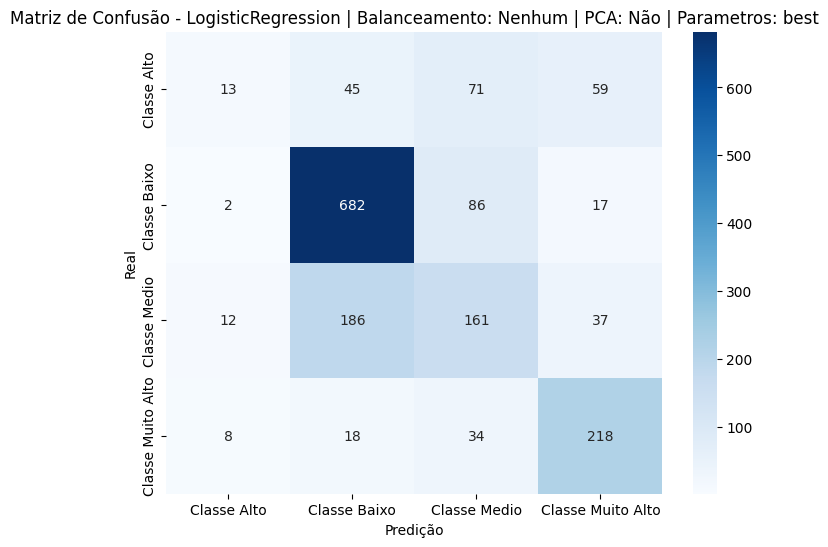


Relatório de Classificação para LogisticRegression | Balanceamento: Nenhum | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.37      0.07      0.12       188
     Classe Baixo       0.73      0.87      0.79       787
     Classe Medio       0.46      0.41      0.43       396
Classe Muito Alto       0.66      0.78      0.72       278

         accuracy                           0.65      1649
        macro avg       0.55      0.53      0.51      1649
     weighted avg       0.61      0.65      0.62      1649

Tempo de treinamento: 9.5823 segundos

==================== RandomForest ====================
Atenção ⚠️: Não encontrei parâmetros salvos para RandomForest, usando default.


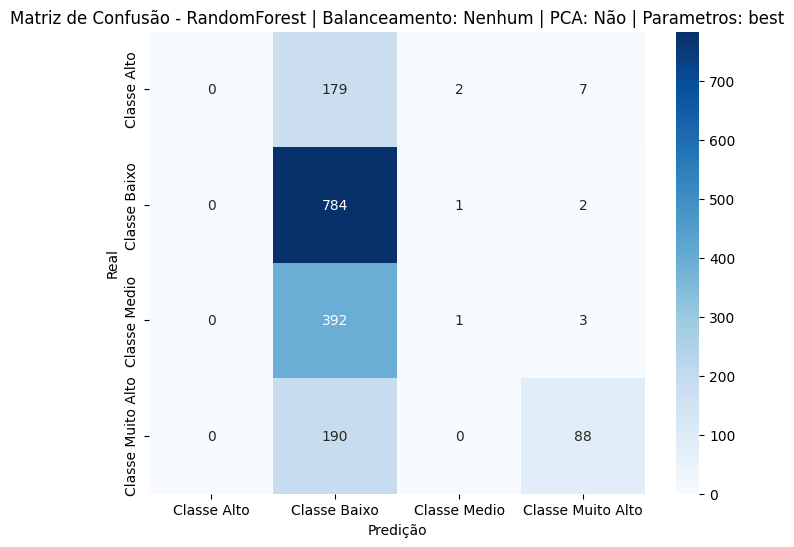


Relatório de Classificação para RandomForest | Balanceamento: Nenhum | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.00      0.00      0.00       188
     Classe Baixo       0.51      1.00      0.67       787
     Classe Medio       0.25      0.00      0.01       396
Classe Muito Alto       0.88      0.32      0.47       278

         accuracy                           0.53      1649
        macro avg       0.41      0.33      0.29      1649
     weighted avg       0.45      0.53      0.40      1649

Tempo de treinamento: 2.6746 segundos

==================== SVM ====================
Atenção ⚠️: Não encontrei parâmetros salvos para SVM, usando default.


/home/fbotero/Downloads/imoveis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/fbotero/Downloads/imoveis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/fbotero/Downloads/imoveis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

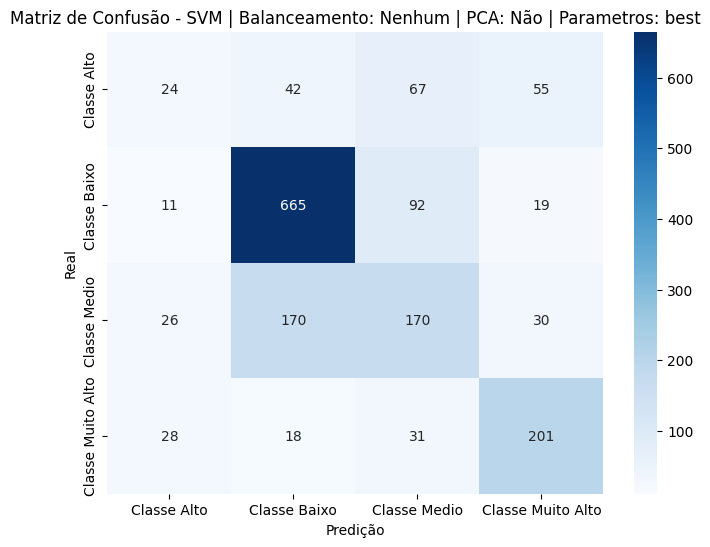


Relatório de Classificação para SVM | Balanceamento: Nenhum | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.27      0.13      0.17       188
     Classe Baixo       0.74      0.84      0.79       787
     Classe Medio       0.47      0.43      0.45       396
Classe Muito Alto       0.66      0.72      0.69       278

         accuracy                           0.64      1649
        macro avg       0.54      0.53      0.53      1649
     weighted avg       0.61      0.64      0.62      1649

Tempo de treinamento: 14.5038 segundos

==================== KNN ====================
Atenção ⚠️: Não encontrei parâmetros salvos para KNN, usando default.


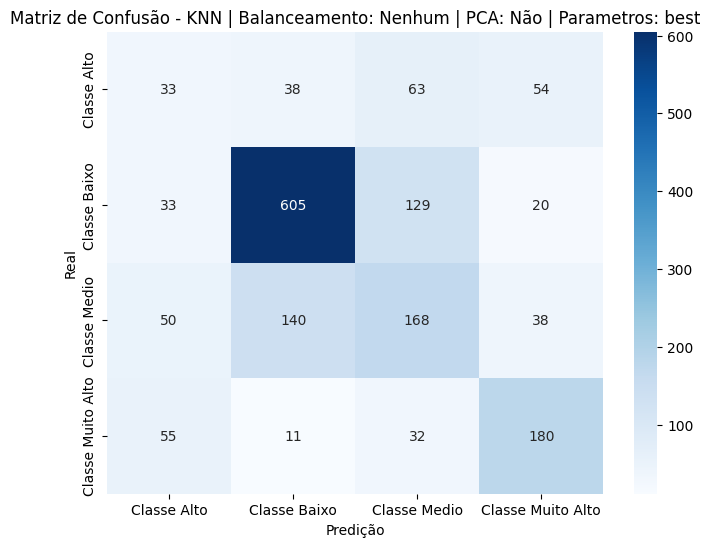


Relatório de Classificação para KNN | Balanceamento: Nenhum | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.19      0.18      0.18       188
     Classe Baixo       0.76      0.77      0.77       787
     Classe Medio       0.43      0.42      0.43       396
Classe Muito Alto       0.62      0.65      0.63       278

         accuracy                           0.60      1649
        macro avg       0.50      0.50      0.50      1649
     weighted avg       0.59      0.60      0.60      1649

Tempo de treinamento: 0.0060 segundos

==================== DecisionTree ====================
Atenção ⚠️: Não encontrei parâmetros salvos para DecisionTree, usando default.


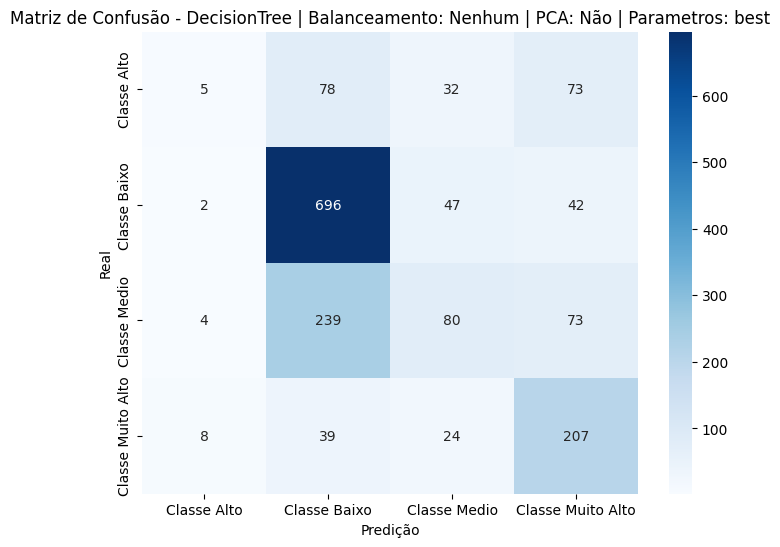


Relatório de Classificação para DecisionTree | Balanceamento: Nenhum | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.26      0.03      0.05       188
     Classe Baixo       0.66      0.88      0.76       787
     Classe Medio       0.44      0.20      0.28       396
Classe Muito Alto       0.52      0.74      0.62       278

         accuracy                           0.60      1649
        macro avg       0.47      0.46      0.42      1649
     weighted avg       0.54      0.60      0.54      1649

Tempo de treinamento: 0.1907 segundos

==================== NeuralNetwork ====================
Atenção ⚠️: Não encontrei parâmetros salvos para NeuralNetwork, usando default.


/home/fbotero/Downloads/imoveis/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


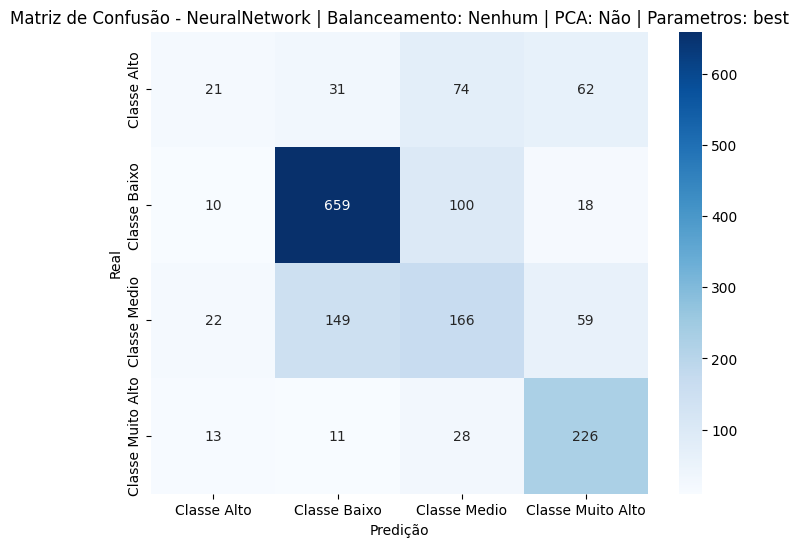


Relatório de Classificação para NeuralNetwork | Balanceamento: Nenhum | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.32      0.11      0.17       188
     Classe Baixo       0.78      0.84      0.81       787
     Classe Medio       0.45      0.42      0.43       396
Classe Muito Alto       0.62      0.81      0.70       278

         accuracy                           0.65      1649
        macro avg       0.54      0.55      0.53      1649
     weighted avg       0.62      0.65      0.63      1649

Tempo de treinamento: 21.0128 segundos

==================== NaiveBayes ====================


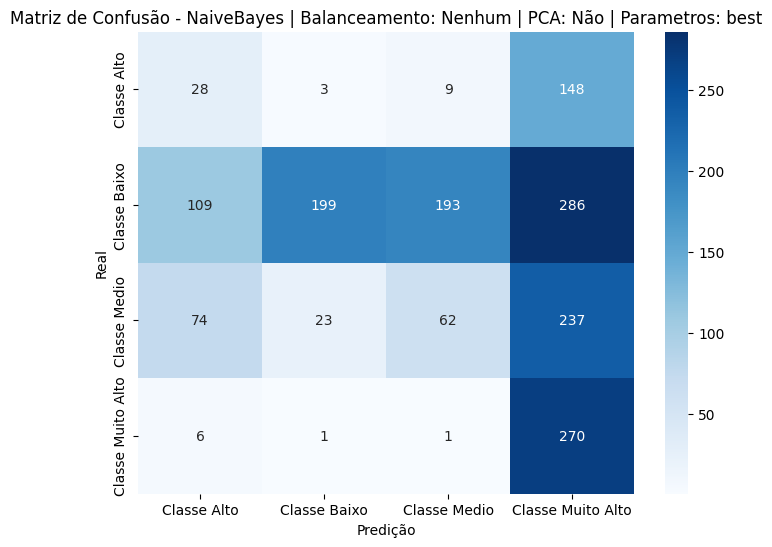


Relatório de Classificação para NaiveBayes | Balanceamento: Nenhum | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.13      0.15      0.14       188
     Classe Baixo       0.88      0.25      0.39       787
     Classe Medio       0.23      0.16      0.19       396
Classe Muito Alto       0.29      0.97      0.44       278

         accuracy                           0.34      1649
        macro avg       0.38      0.38      0.29      1649
     weighted avg       0.54      0.34      0.32      1649

Tempo de treinamento: 0.0617 segundos


,Modelo,Acurácia Teste,Tempo Treinamento (s),Melhores Parâmetros
0,LogisticRegression | Balanceamento: Nenhum | P...,0.651304,9.582273,N/A
5,NeuralNetwork | Balanceamento: Nenhum | PCA: N...,0.650091,21.012808,N/A
2,SVM | Balanceamento: Nenhum | PCA: Não | Param...,0.642814,14.503765,N/A
4,DecisionTree | Balanceamento: Nenhum | PCA: Nã...,0.599151,0.190709,N/A
3,KNN | Balanceamento: Nenhum | PCA: Não | Param...,0.597938,0.005971,N/A
1,RandomForest | Balanceamento: Nenhum | PCA: Nã...,0.529412,2.674647,N/A
6,NaiveBayes | Balanceamento: Nenhum | PCA: Não ...,0.338993,0.061744,N/A


✨ Melhor modelo salvo: LogisticRegression com acurácia de 0.6513!

==================== LogisticRegression ====================
Atenção ⚠️: Não encontrei parâmetros salvos para LogisticRegression, usando default.
✨ Novo melhor modelo encontrado: LogisticRegression | Balanceamento: smote | PCA: Não | Parametros: best com acurácia de 0.6513!


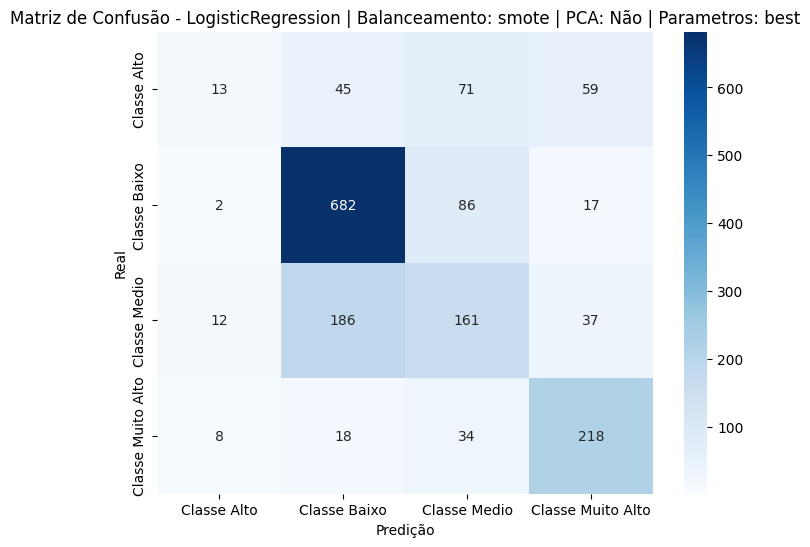


Relatório de Classificação para LogisticRegression | Balanceamento: smote | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.37      0.07      0.12       188
     Classe Baixo       0.73      0.87      0.79       787
     Classe Medio       0.46      0.41      0.43       396
Classe Muito Alto       0.66      0.78      0.72       278

         accuracy                           0.65      1649
        macro avg       0.55      0.53      0.51      1649
     weighted avg       0.61      0.65      0.62      1649

Tempo de treinamento: 9.6153 segundos

==================== RandomForest ====================
Atenção ⚠️: Não encontrei parâmetros salvos para RandomForest, usando default.


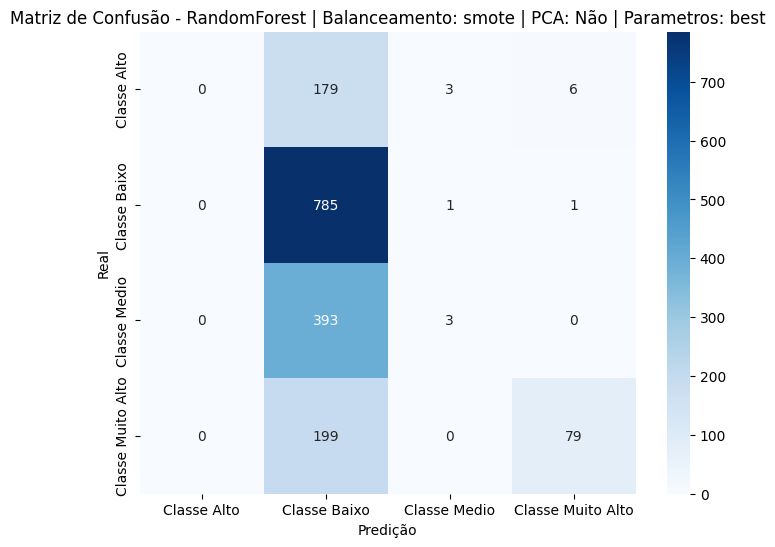


Relatório de Classificação para RandomForest | Balanceamento: smote | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.00      0.00      0.00       188
     Classe Baixo       0.50      1.00      0.67       787
     Classe Medio       0.43      0.01      0.01       396
Classe Muito Alto       0.92      0.28      0.43       278

         accuracy                           0.53      1649
        macro avg       0.46      0.32      0.28      1649
     weighted avg       0.50      0.53      0.40      1649

Tempo de treinamento: 2.6135 segundos

==================== SVM ====================
Atenção ⚠️: Não encontrei parâmetros salvos para SVM, usando default.


/home/fbotero/Downloads/imoveis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/fbotero/Downloads/imoveis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/fbotero/Downloads/imoveis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

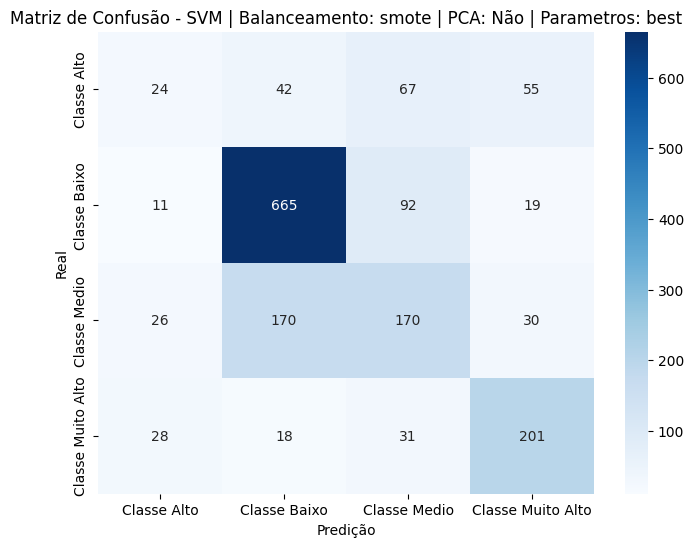


Relatório de Classificação para SVM | Balanceamento: smote | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.27      0.13      0.17       188
     Classe Baixo       0.74      0.84      0.79       787
     Classe Medio       0.47      0.43      0.45       396
Classe Muito Alto       0.66      0.72      0.69       278

         accuracy                           0.64      1649
        macro avg       0.54      0.53      0.53      1649
     weighted avg       0.61      0.64      0.62      1649

Tempo de treinamento: 14.3607 segundos

==================== KNN ====================
Atenção ⚠️: Não encontrei parâmetros salvos para KNN, usando default.


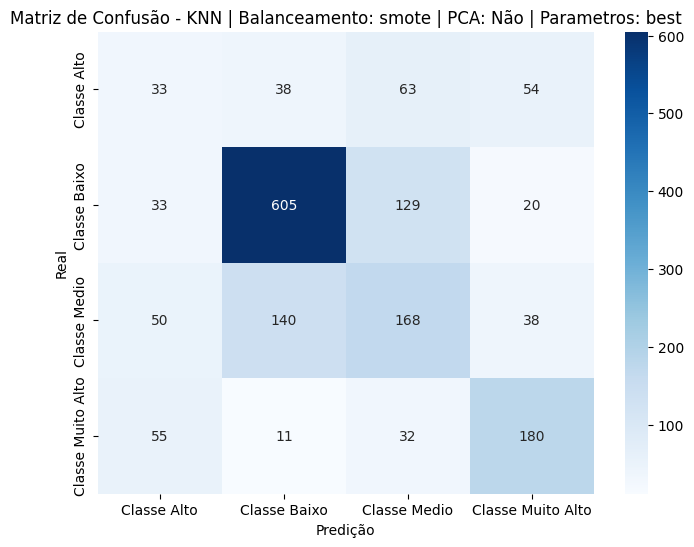


Relatório de Classificação para KNN | Balanceamento: smote | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.19      0.18      0.18       188
     Classe Baixo       0.76      0.77      0.77       787
     Classe Medio       0.43      0.42      0.43       396
Classe Muito Alto       0.62      0.65      0.63       278

         accuracy                           0.60      1649
        macro avg       0.50      0.50      0.50      1649
     weighted avg       0.59      0.60      0.60      1649

Tempo de treinamento: 0.0056 segundos

==================== DecisionTree ====================
Atenção ⚠️: Não encontrei parâmetros salvos para DecisionTree, usando default.


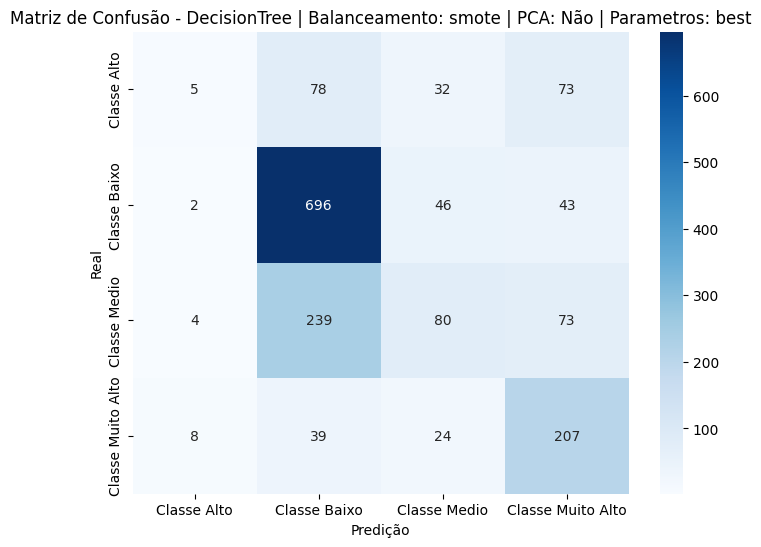


Relatório de Classificação para DecisionTree | Balanceamento: smote | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.26      0.03      0.05       188
     Classe Baixo       0.66      0.88      0.76       787
     Classe Medio       0.44      0.20      0.28       396
Classe Muito Alto       0.52      0.74      0.61       278

         accuracy                           0.60      1649
        macro avg       0.47      0.46      0.42      1649
     weighted avg       0.54      0.60      0.54      1649

Tempo de treinamento: 0.1984 segundos

==================== NeuralNetwork ====================
Atenção ⚠️: Não encontrei parâmetros salvos para NeuralNetwork, usando default.


/home/fbotero/Downloads/imoveis/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


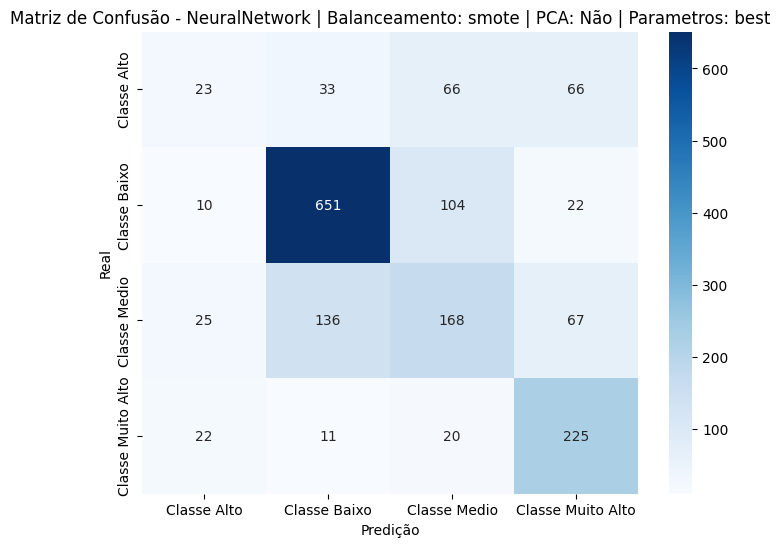


Relatório de Classificação para NeuralNetwork | Balanceamento: smote | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.29      0.12      0.17       188
     Classe Baixo       0.78      0.83      0.80       787
     Classe Medio       0.47      0.42      0.45       396
Classe Muito Alto       0.59      0.81      0.68       278

         accuracy                           0.65      1649
        macro avg       0.53      0.55      0.53      1649
     weighted avg       0.62      0.65      0.63      1649

Tempo de treinamento: 20.9427 segundos

==================== NaiveBayes ====================


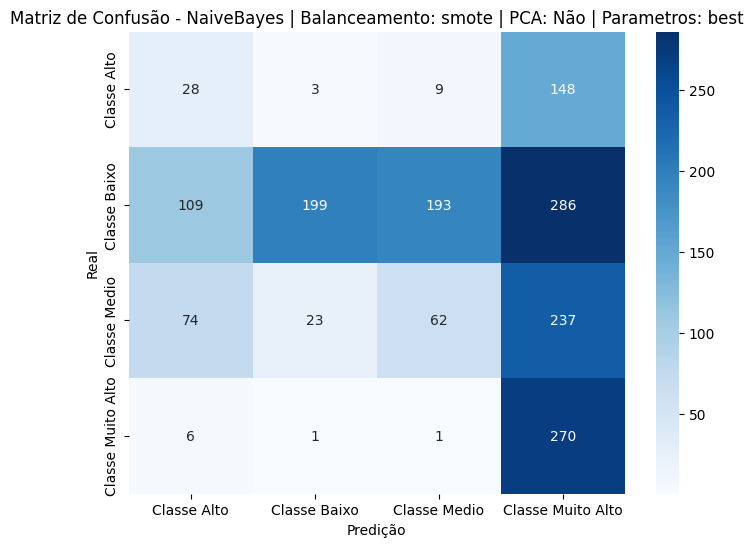


Relatório de Classificação para NaiveBayes | Balanceamento: smote | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.13      0.15      0.14       188
     Classe Baixo       0.88      0.25      0.39       787
     Classe Medio       0.23      0.16      0.19       396
Classe Muito Alto       0.29      0.97      0.44       278

         accuracy                           0.34      1649
        macro avg       0.38      0.38      0.29      1649
     weighted avg       0.54      0.34      0.32      1649

Tempo de treinamento: 0.0606 segundos


,Modelo,Acurácia Teste,Tempo Treinamento (s),Melhores Parâmetros
0,LogisticRegression | Balanceamento: smote | PC...,0.651304,9.615293,N/A
5,NeuralNetwork | Balanceamento: smote | PCA: Nã...,0.647059,20.942727,N/A
2,SVM | Balanceamento: smote | PCA: Não | Parame...,0.642814,14.360680,N/A
4,DecisionTree | Balanceamento: smote | PCA: Não...,0.599151,0.198387,N/A
3,KNN | Balanceamento: smote | PCA: Não | Parame...,0.597938,0.005584,N/A
1,RandomForest | Balanceamento: smote | PCA: Não...,0.525773,2.613496,N/A
6,NaiveBayes | Balanceamento: smote | PCA: Não |...,0.338993,0.060639,N/A


✨ Melhor modelo salvo: LogisticRegression com acurácia de 0.6513!

==================== LogisticRegression ====================
Atenção ⚠️: Não encontrei parâmetros salvos para LogisticRegression, usando default.
✨ Novo melhor modelo encontrado: LogisticRegression | Balanceamento: tomek | PCA: Não | Parametros: best com acurácia de 0.6513!


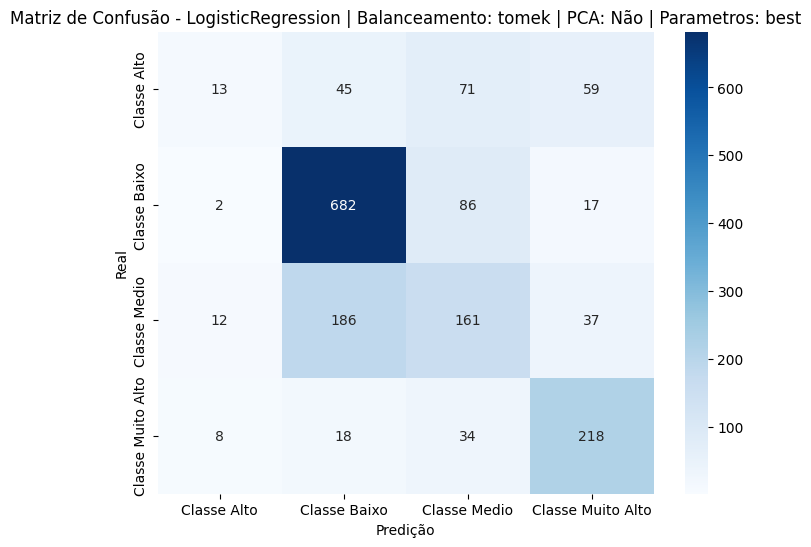


Relatório de Classificação para LogisticRegression | Balanceamento: tomek | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.37      0.07      0.12       188
     Classe Baixo       0.73      0.87      0.79       787
     Classe Medio       0.46      0.41      0.43       396
Classe Muito Alto       0.66      0.78      0.72       278

         accuracy                           0.65      1649
        macro avg       0.55      0.53      0.51      1649
     weighted avg       0.61      0.65      0.62      1649

Tempo de treinamento: 9.6264 segundos

==================== RandomForest ====================
Atenção ⚠️: Não encontrei parâmetros salvos para RandomForest, usando default.


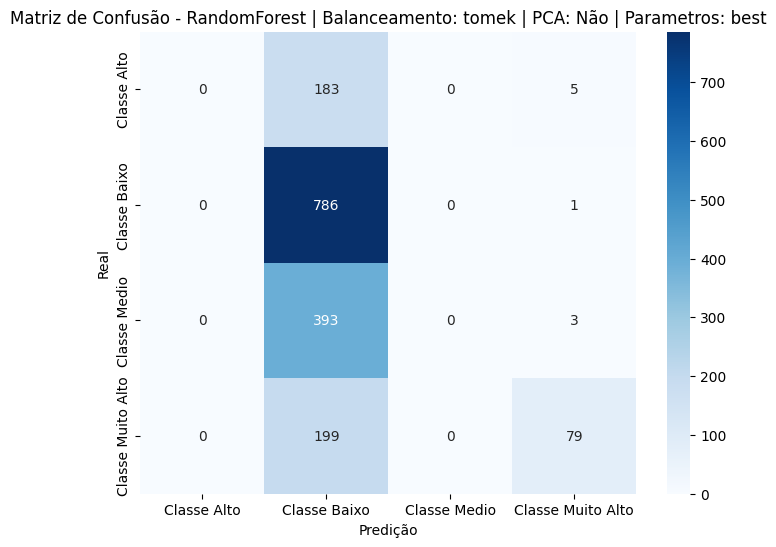


Relatório de Classificação para RandomForest | Balanceamento: tomek | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.00      0.00      0.00       188
     Classe Baixo       0.50      1.00      0.67       787
     Classe Medio       0.00      0.00      0.00       396
Classe Muito Alto       0.90      0.28      0.43       278

         accuracy                           0.52      1649
        macro avg       0.35      0.32      0.28      1649
     weighted avg       0.39      0.52      0.39      1649

Tempo de treinamento: 2.6247 segundos

==================== SVM ====================
Atenção ⚠️: Não encontrei parâmetros salvos para SVM, usando default.


/home/fbotero/Downloads/imoveis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/fbotero/Downloads/imoveis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/fbotero/Downloads/imoveis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

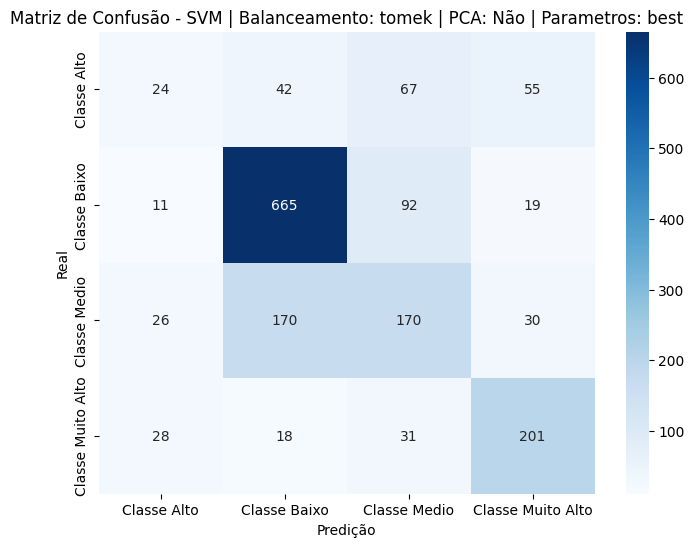


Relatório de Classificação para SVM | Balanceamento: tomek | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.27      0.13      0.17       188
     Classe Baixo       0.74      0.84      0.79       787
     Classe Medio       0.47      0.43      0.45       396
Classe Muito Alto       0.66      0.72      0.69       278

         accuracy                           0.64      1649
        macro avg       0.54      0.53      0.53      1649
     weighted avg       0.61      0.64      0.62      1649

Tempo de treinamento: 14.4103 segundos

==================== KNN ====================
Atenção ⚠️: Não encontrei parâmetros salvos para KNN, usando default.


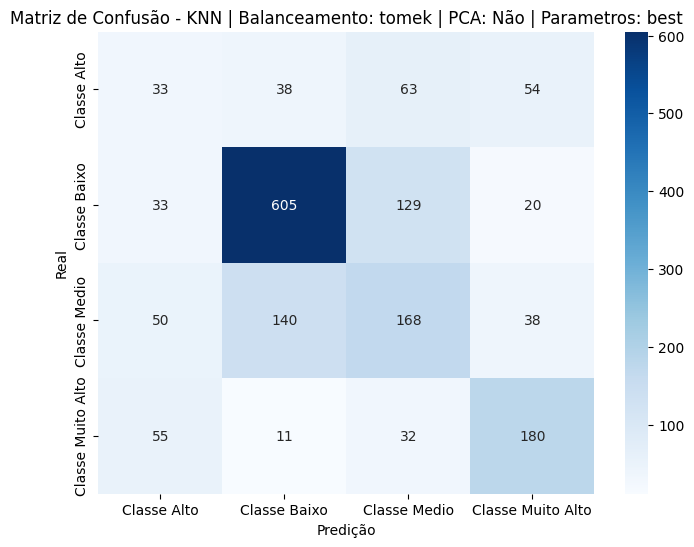


Relatório de Classificação para KNN | Balanceamento: tomek | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.19      0.18      0.18       188
     Classe Baixo       0.76      0.77      0.77       787
     Classe Medio       0.43      0.42      0.43       396
Classe Muito Alto       0.62      0.65      0.63       278

         accuracy                           0.60      1649
        macro avg       0.50      0.50      0.50      1649
     weighted avg       0.59      0.60      0.60      1649

Tempo de treinamento: 0.0063 segundos

==================== DecisionTree ====================
Atenção ⚠️: Não encontrei parâmetros salvos para DecisionTree, usando default.


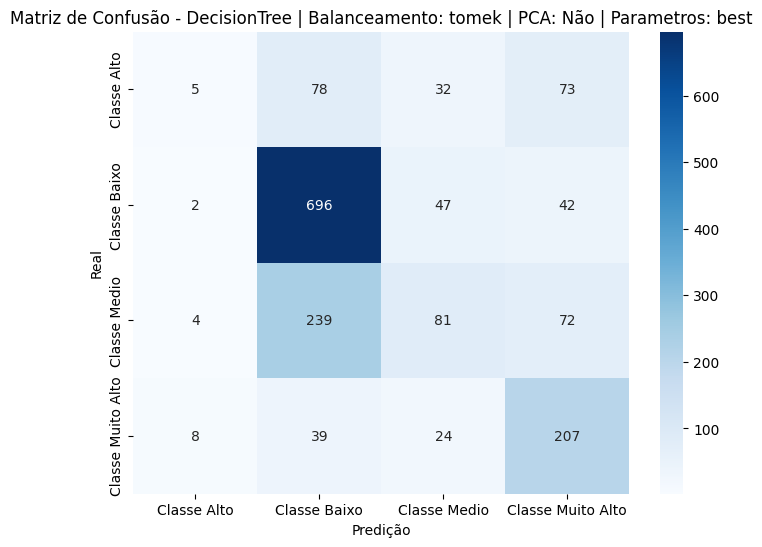


Relatório de Classificação para DecisionTree | Balanceamento: tomek | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.26      0.03      0.05       188
     Classe Baixo       0.66      0.88      0.76       787
     Classe Medio       0.44      0.20      0.28       396
Classe Muito Alto       0.53      0.74      0.62       278

         accuracy                           0.60      1649
        macro avg       0.47      0.47      0.43      1649
     weighted avg       0.54      0.60      0.54      1649

Tempo de treinamento: 0.2042 segundos

==================== NeuralNetwork ====================
Atenção ⚠️: Não encontrei parâmetros salvos para NeuralNetwork, usando default.


/home/fbotero/Downloads/imoveis/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


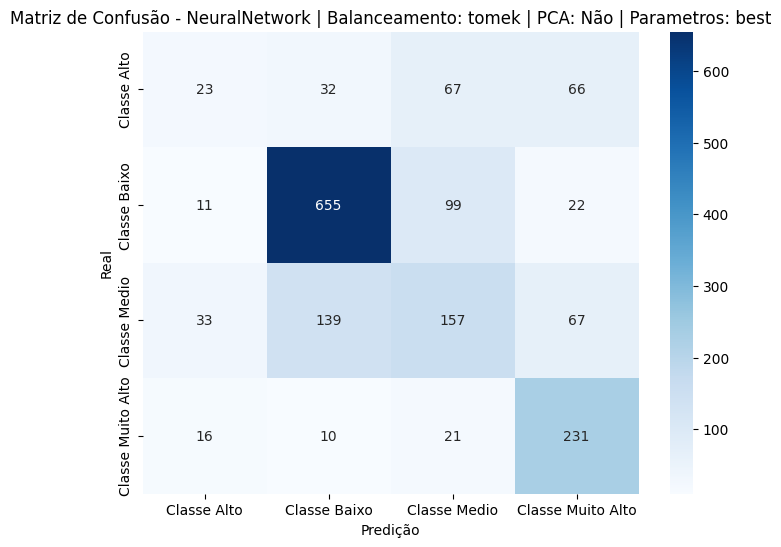


Relatório de Classificação para NeuralNetwork | Balanceamento: tomek | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.28      0.12      0.17       188
     Classe Baixo       0.78      0.83      0.81       787
     Classe Medio       0.46      0.40      0.42       396
Classe Muito Alto       0.60      0.83      0.70       278

         accuracy                           0.65      1649
        macro avg       0.53      0.55      0.52      1649
     weighted avg       0.62      0.65      0.62      1649

Tempo de treinamento: 20.9481 segundos

==================== NaiveBayes ====================


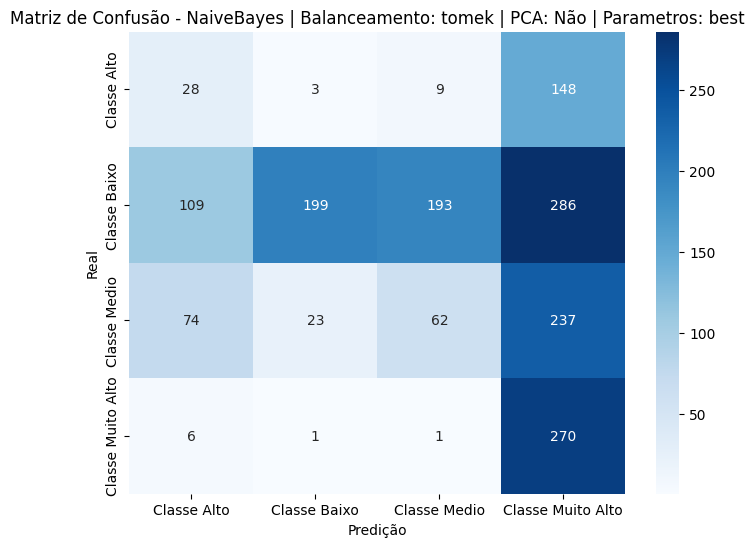


Relatório de Classificação para NaiveBayes | Balanceamento: tomek | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.13      0.15      0.14       188
     Classe Baixo       0.88      0.25      0.39       787
     Classe Medio       0.23      0.16      0.19       396
Classe Muito Alto       0.29      0.97      0.44       278

         accuracy                           0.34      1649
        macro avg       0.38      0.38      0.29      1649
     weighted avg       0.54      0.34      0.32      1649

Tempo de treinamento: 0.0685 segundos


,Modelo,Acurácia Teste,Tempo Treinamento (s),Melhores Parâmetros
0,LogisticRegression | Balanceamento: tomek | PC...,0.651304,9.626359,N/A
5,NeuralNetwork | Balanceamento: tomek | PCA: Nã...,0.646452,20.948091,N/A
2,SVM | Balanceamento: tomek | PCA: Não | Parame...,0.642814,14.410265,N/A
4,DecisionTree | Balanceamento: tomek | PCA: Não...,0.599757,0.204195,N/A
3,KNN | Balanceamento: tomek | PCA: Não | Parame...,0.597938,0.006269,N/A
1,RandomForest | Balanceamento: tomek | PCA: Não...,0.524560,2.624723,N/A
6,NaiveBayes | Balanceamento: tomek | PCA: Não |...,0.338993,0.068469,N/A


✨ Melhor modelo salvo: LogisticRegression com acurácia de 0.6513!

==================== LogisticRegression ====================
Atenção ⚠️: Não encontrei parâmetros salvos para LogisticRegression, usando default.
✨ Novo melhor modelo encontrado: LogisticRegression | Balanceamento: smote | PCA: Sim | Parametros: best com acurácia de 0.6246!


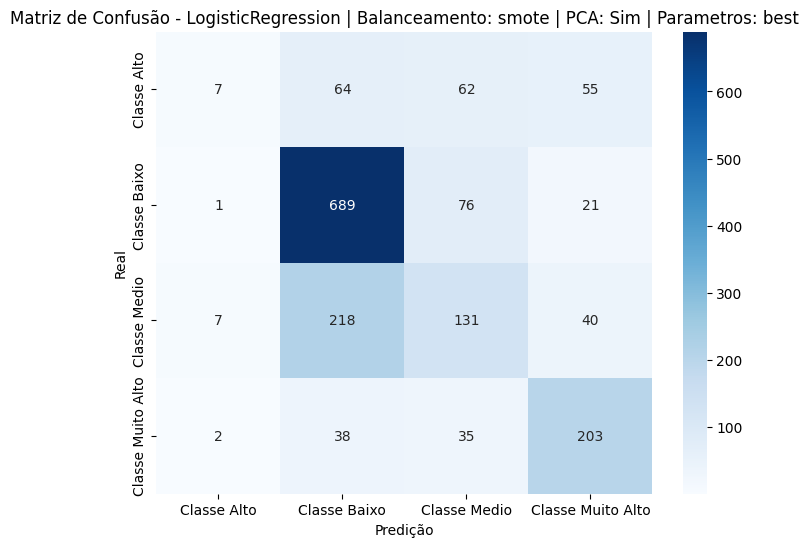


Relatório de Classificação para LogisticRegression | Balanceamento: smote | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.41      0.04      0.07       188
     Classe Baixo       0.68      0.88      0.77       787
     Classe Medio       0.43      0.33      0.37       396
Classe Muito Alto       0.64      0.73      0.68       278

         accuracy                           0.62      1649
        macro avg       0.54      0.49      0.47      1649
     weighted avg       0.58      0.62      0.58      1649

Tempo de treinamento: 5.1061 segundos

==================== RandomForest ====================
Atenção ⚠️: Não encontrei parâmetros salvos para RandomForest, usando default.
✨ Novo melhor modelo encontrado: RandomForest | Balanceamento: smote | PCA: Sim | Parametros: best com acurácia de 0.6398!


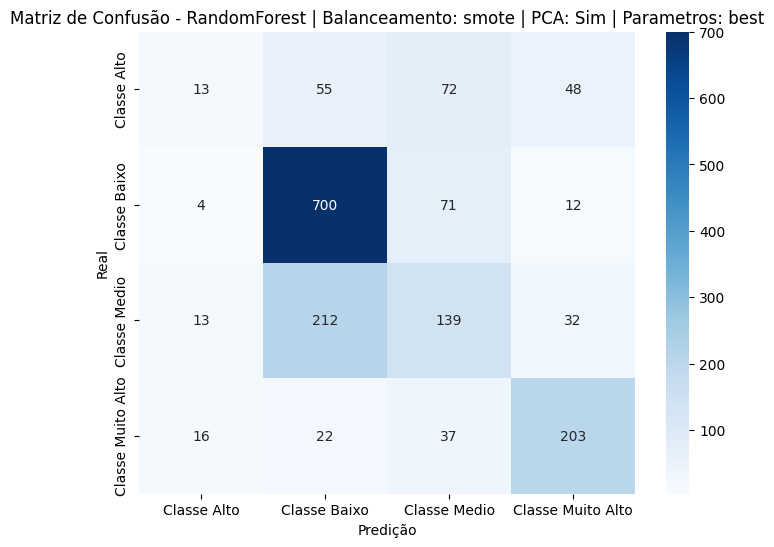


Relatório de Classificação para RandomForest | Balanceamento: smote | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.28      0.07      0.11       188
     Classe Baixo       0.71      0.89      0.79       787
     Classe Medio       0.44      0.35      0.39       396
Classe Muito Alto       0.69      0.73      0.71       278

         accuracy                           0.64      1649
        macro avg       0.53      0.51      0.50      1649
     weighted avg       0.59      0.64      0.60      1649

Tempo de treinamento: 13.2459 segundos

==================== SVM ====================
Atenção ⚠️: Não encontrei parâmetros salvos para SVM, usando default.


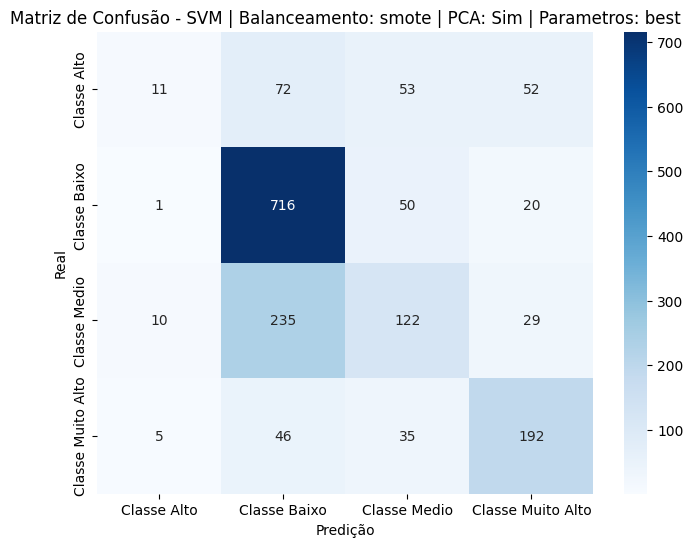


Relatório de Classificação para SVM | Balanceamento: smote | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.41      0.06      0.10       188
     Classe Baixo       0.67      0.91      0.77       787
     Classe Medio       0.47      0.31      0.37       396
Classe Muito Alto       0.66      0.69      0.67       278

         accuracy                           0.63      1649
        macro avg       0.55      0.49      0.48      1649
     weighted avg       0.59      0.63      0.58      1649

Tempo de treinamento: 2.7386 segundos

==================== KNN ====================
Atenção ⚠️: Não encontrei parâmetros salvos para KNN, usando default.


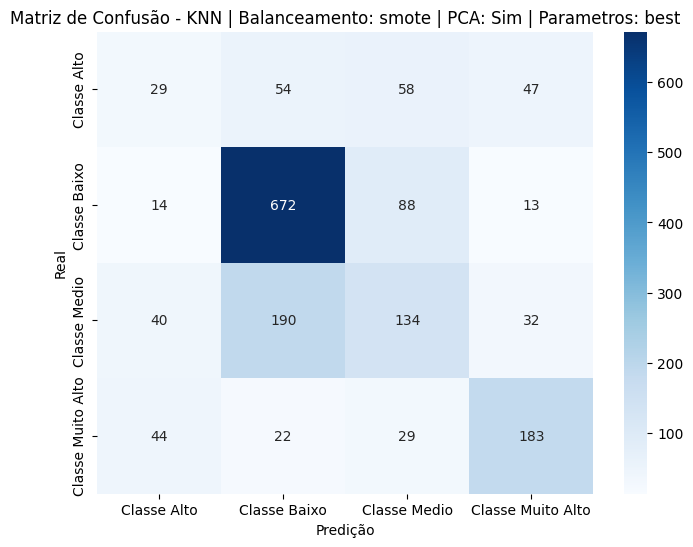


Relatório de Classificação para KNN | Balanceamento: smote | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.23      0.15      0.18       188
     Classe Baixo       0.72      0.85      0.78       787
     Classe Medio       0.43      0.34      0.38       396
Classe Muito Alto       0.67      0.66      0.66       278

         accuracy                           0.62      1649
        macro avg       0.51      0.50      0.50      1649
     weighted avg       0.58      0.62      0.60      1649

Tempo de treinamento: 0.0053 segundos

==================== DecisionTree ====================
Atenção ⚠️: Não encontrei parâmetros salvos para DecisionTree, usando default.


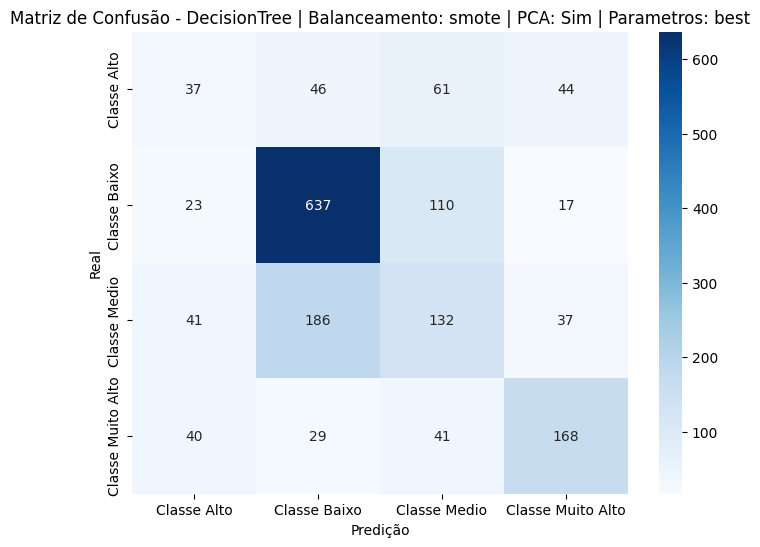


Relatório de Classificação para DecisionTree | Balanceamento: smote | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.26      0.20      0.22       188
     Classe Baixo       0.71      0.81      0.76       787
     Classe Medio       0.38      0.33      0.36       396
Classe Muito Alto       0.63      0.60      0.62       278

         accuracy                           0.59      1649
        macro avg       0.50      0.49      0.49      1649
     weighted avg       0.57      0.59      0.58      1649

Tempo de treinamento: 0.6514 segundos

==================== NeuralNetwork ====================
Atenção ⚠️: Não encontrei parâmetros salvos para NeuralNetwork, usando default.
✨ Novo melhor modelo encontrado: NeuralNetwork | Balanceamento: smote | PCA: Sim | Parametros: best com acurácia de 0.6410!


/home/fbotero/Downloads/imoveis/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


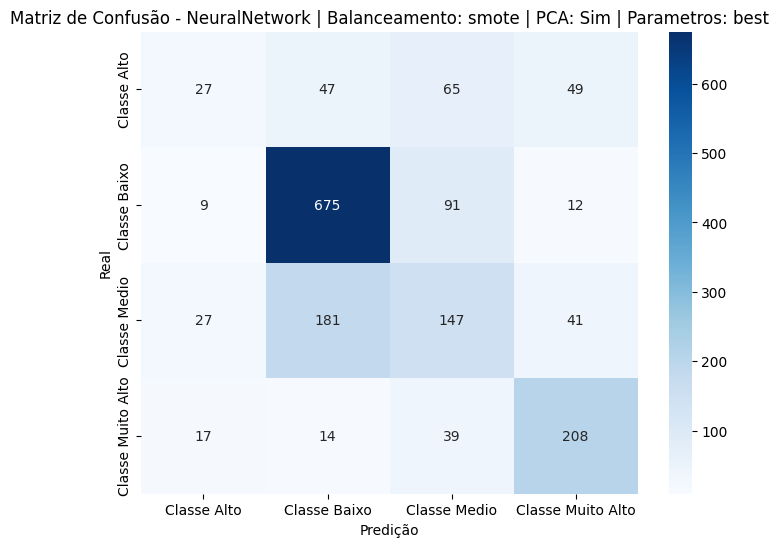


Relatório de Classificação para NeuralNetwork | Balanceamento: smote | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.34      0.14      0.20       188
     Classe Baixo       0.74      0.86      0.79       787
     Classe Medio       0.43      0.37      0.40       396
Classe Muito Alto       0.67      0.75      0.71       278

         accuracy                           0.64      1649
        macro avg       0.54      0.53      0.52      1649
     weighted avg       0.61      0.64      0.62      1649

Tempo de treinamento: 5.9671 segundos

==================== NaiveBayes ====================


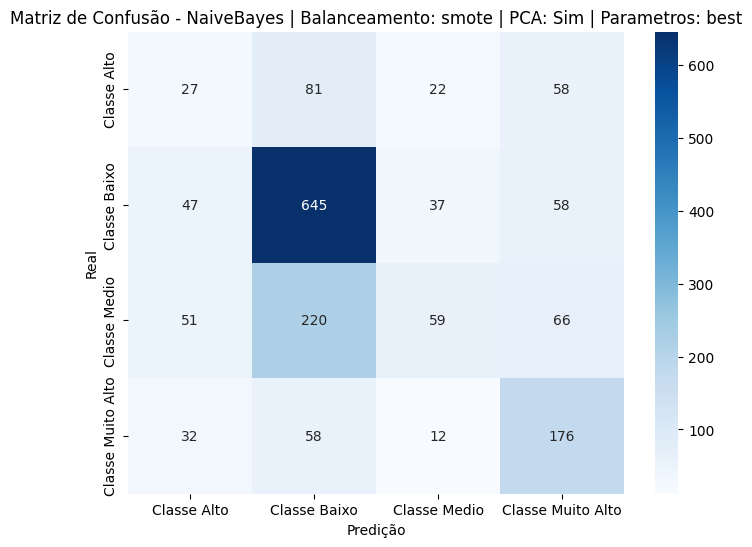


Relatório de Classificação para NaiveBayes | Balanceamento: smote | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.17      0.14      0.16       188
     Classe Baixo       0.64      0.82      0.72       787
     Classe Medio       0.45      0.15      0.22       396
Classe Muito Alto       0.49      0.63      0.55       278

         accuracy                           0.55      1649
        macro avg       0.44      0.44      0.41      1649
     weighted avg       0.52      0.55      0.51      1649

Tempo de treinamento: 0.0096 segundos


,Modelo,Acurácia Teste,Tempo Treinamento (s),Melhores Parâmetros
5,NeuralNetwork | Balanceamento: smote | PCA: Si...,0.640995,5.967108,N/A
1,RandomForest | Balanceamento: smote | PCA: Sim...,0.639782,13.245941,N/A
2,SVM | Balanceamento: smote | PCA: Sim | Parame...,0.631292,2.738595,N/A
0,LogisticRegression | Balanceamento: smote | PC...,0.624621,5.106077,N/A
3,KNN | Balanceamento: smote | PCA: Sim | Parame...,0.617344,0.005347,N/A
4,DecisionTree | Balanceamento: smote | PCA: Sim...,0.590661,0.651421,N/A
6,NaiveBayes | Balanceamento: smote | PCA: Sim |...,0.550030,0.009566,N/A


✨ Melhor modelo salvo: NeuralNetwork com acurácia de 0.6410!

==================== LogisticRegression ====================
Atenção ⚠️: Não encontrei parâmetros salvos para LogisticRegression, usando default.
✨ Novo melhor modelo encontrado: LogisticRegression | Balanceamento: tomek | PCA: Sim | Parametros: best com acurácia de 0.6264!


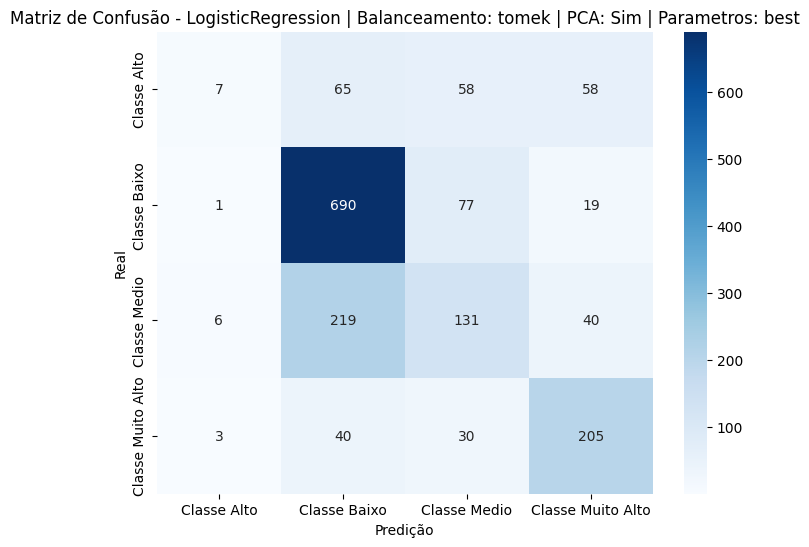


Relatório de Classificação para LogisticRegression | Balanceamento: tomek | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.41      0.04      0.07       188
     Classe Baixo       0.68      0.88      0.77       787
     Classe Medio       0.44      0.33      0.38       396
Classe Muito Alto       0.64      0.74      0.68       278

         accuracy                           0.63      1649
        macro avg       0.54      0.50      0.47      1649
     weighted avg       0.59      0.63      0.58      1649

Tempo de treinamento: 4.9018 segundos

==================== RandomForest ====================
Atenção ⚠️: Não encontrei parâmetros salvos para RandomForest, usando default.
✨ Novo melhor modelo encontrado: RandomForest | Balanceamento: tomek | PCA: Sim | Parametros: best com acurácia de 0.6404!


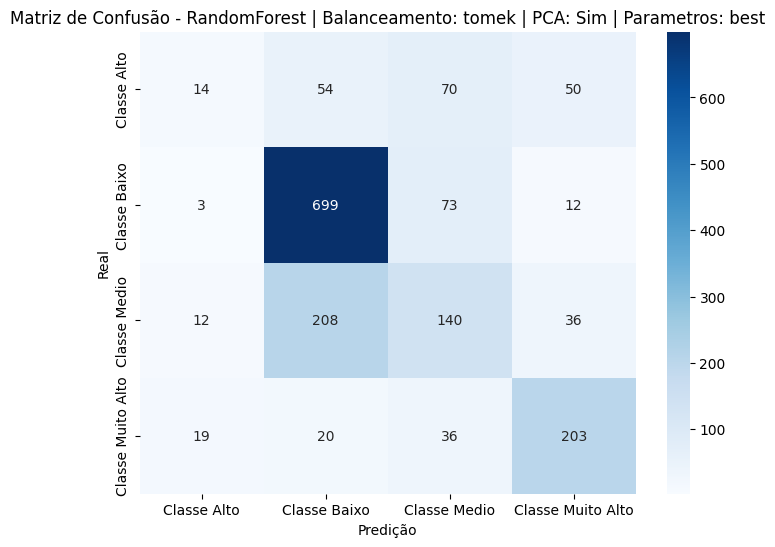


Relatório de Classificação para RandomForest | Balanceamento: tomek | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.29      0.07      0.12       188
     Classe Baixo       0.71      0.89      0.79       787
     Classe Medio       0.44      0.35      0.39       396
Classe Muito Alto       0.67      0.73      0.70       278

         accuracy                           0.64      1649
        macro avg       0.53      0.51      0.50      1649
     weighted avg       0.59      0.64      0.60      1649

Tempo de treinamento: 13.1792 segundos

==================== SVM ====================
Atenção ⚠️: Não encontrei parâmetros salvos para SVM, usando default.


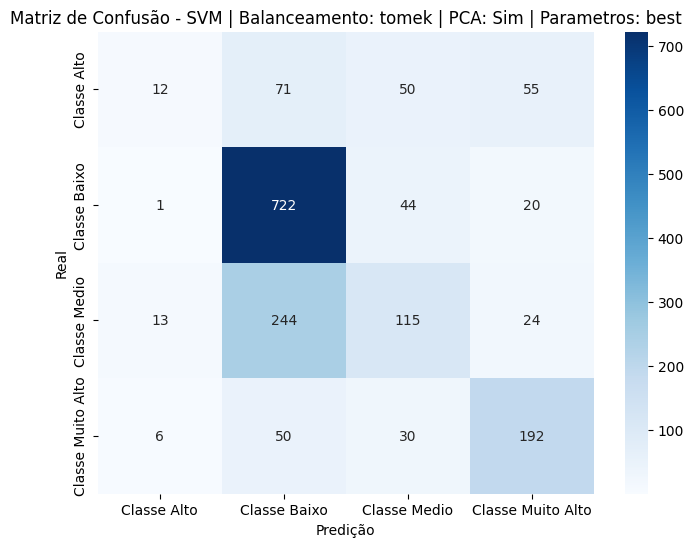


Relatório de Classificação para SVM | Balanceamento: tomek | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.38      0.06      0.11       188
     Classe Baixo       0.66      0.92      0.77       787
     Classe Medio       0.48      0.29      0.36       396
Classe Muito Alto       0.66      0.69      0.67       278

         accuracy                           0.63      1649
        macro avg       0.55      0.49      0.48      1649
     weighted avg       0.59      0.63      0.58      1649

Tempo de treinamento: 2.8111 segundos

==================== KNN ====================
Atenção ⚠️: Não encontrei parâmetros salvos para KNN, usando default.


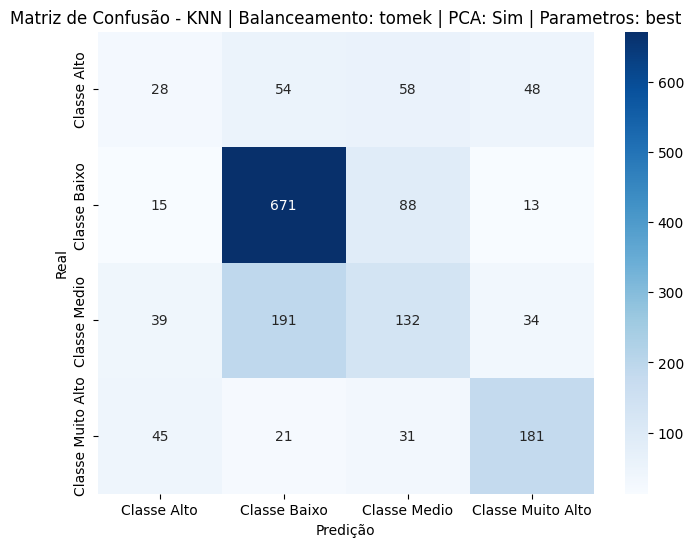


Relatório de Classificação para KNN | Balanceamento: tomek | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.22      0.15      0.18       188
     Classe Baixo       0.72      0.85      0.78       787
     Classe Medio       0.43      0.33      0.37       396
Classe Muito Alto       0.66      0.65      0.65       278

         accuracy                           0.61      1649
        macro avg       0.50      0.50      0.50      1649
     weighted avg       0.58      0.61      0.59      1649

Tempo de treinamento: 0.0060 segundos

==================== DecisionTree ====================
Atenção ⚠️: Não encontrei parâmetros salvos para DecisionTree, usando default.


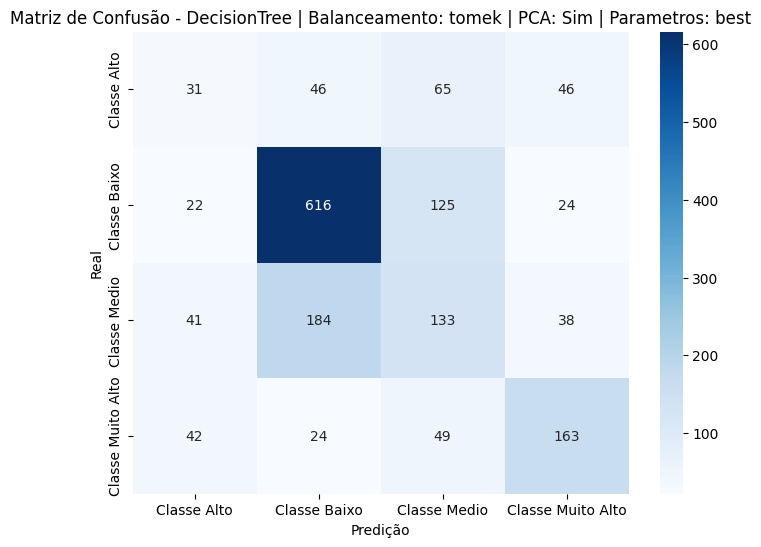


Relatório de Classificação para DecisionTree | Balanceamento: tomek | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.23      0.16      0.19       188
     Classe Baixo       0.71      0.78      0.74       787
     Classe Medio       0.36      0.34      0.35       396
Classe Muito Alto       0.60      0.59      0.59       278

         accuracy                           0.57      1649
        macro avg       0.47      0.47      0.47      1649
     weighted avg       0.55      0.57      0.56      1649

Tempo de treinamento: 0.6540 segundos

==================== NeuralNetwork ====================
Atenção ⚠️: Não encontrei parâmetros salvos para NeuralNetwork, usando default.
✨ Novo melhor modelo encontrado: NeuralNetwork | Balanceamento: tomek | PCA: Sim | Parametros: best com acurácia de 0.6410!


/home/fbotero/Downloads/imoveis/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


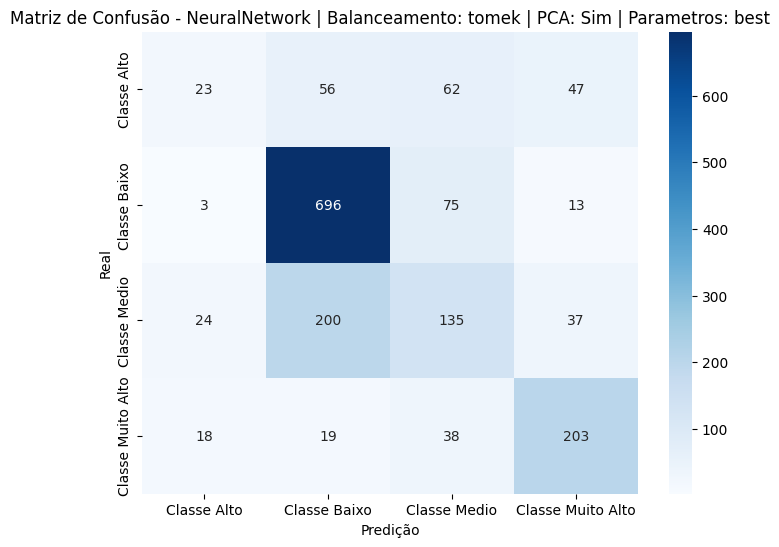


Relatório de Classificação para NeuralNetwork | Balanceamento: tomek | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.34      0.12      0.18       188
     Classe Baixo       0.72      0.88      0.79       787
     Classe Medio       0.44      0.34      0.38       396
Classe Muito Alto       0.68      0.73      0.70       278

         accuracy                           0.64      1649
        macro avg       0.54      0.52      0.51      1649
     weighted avg       0.60      0.64      0.61      1649

Tempo de treinamento: 4.9105 segundos

==================== NaiveBayes ====================


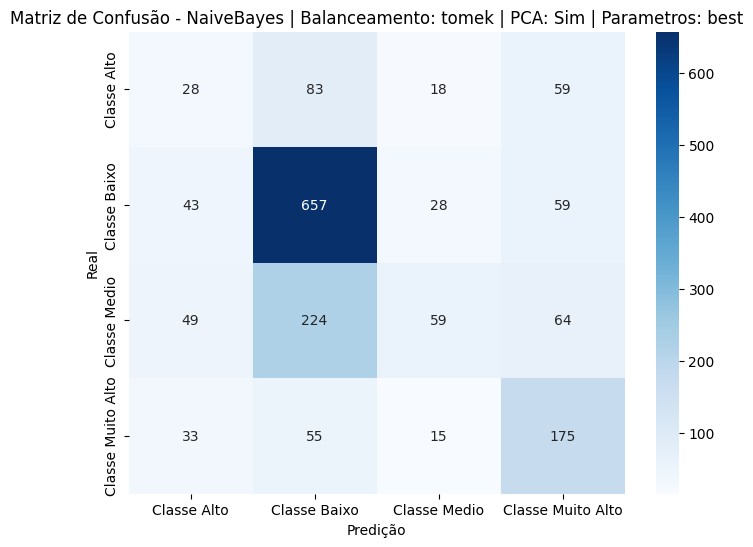


Relatório de Classificação para NaiveBayes | Balanceamento: tomek | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.18      0.15      0.16       188
     Classe Baixo       0.64      0.83      0.73       787
     Classe Medio       0.49      0.15      0.23       396
Classe Muito Alto       0.49      0.63      0.55       278

         accuracy                           0.56      1649
        macro avg       0.45      0.44      0.42      1649
     weighted avg       0.53      0.56      0.51      1649

Tempo de treinamento: 0.0131 segundos


,Modelo,Acurácia Teste,Tempo Treinamento (s),Melhores Parâmetros
5,NeuralNetwork | Balanceamento: tomek | PCA: Si...,0.640995,4.910540,N/A
1,RandomForest | Balanceamento: tomek | PCA: Sim...,0.640388,13.179198,N/A
2,SVM | Balanceamento: tomek | PCA: Sim | Parame...,0.631292,2.811112,N/A
0,LogisticRegression | Balanceamento: tomek | PC...,0.626440,4.901773,N/A
3,KNN | Balanceamento: tomek | PCA: Sim | Parame...,0.613705,0.006008,N/A
4,DecisionTree | Balanceamento: tomek | PCA: Sim...,0.571862,0.653975,N/A
6,NaiveBayes | Balanceamento: tomek | PCA: Sim |...,0.557307,0.013079,N/A


✨ Melhor modelo salvo: NeuralNetwork com acurácia de 0.6410!
Evaluating scenario: best


AttributeError: 'tuple' object has no attribute 'fit'

In [52]:
# Example usage of the treinar_modelos function
scenarios = []

# # Best Parameters
scenarios.append(("best", treinar_modelos(tipo_parametros="best")))
scenarios.append(("best + SMOTE", treinar_modelos(balanceamento="smote", tipo_parametros="best")))
scenarios.append(("best + Tomek", treinar_modelos(balanceamento="tomek", tipo_parametros="best")))
scenarios.append(("best + PCA + SMOTE", treinar_modelos(balanceamento="smote", usar_pca=True, tipo_parametros="best")))
scenarios.append(("best + PCA + Tomek", treinar_modelos(balanceamento="tomek", usar_pca=True, tipo_parametros="best")))

# Iterate through scenarios and evaluate
for name, pipeline in scenarios:
    print(f"Evaluating scenario: {name}")
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    print(f"Score for {name}: {score}")

In [58]:
df_resultados_globais = pd.DataFrame(resultados_global)
df_resultados_globais.head()

df_resultados_globais.to_csv("resultados_globais.csv", index=False)

print("Arquivo 'resultados_globais.csv' salvo com sucesso!")

Arquivo 'resultados_globais.csv' salvo com sucesso!
